In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle

In [4]:
from tqdm import tqdm_notebook as tqdm


In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [6]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mn = 0.602 # mass of N in lattice unit
mpi = 510/ainv # mass of pion in lattice unit

In [7]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import data

In [8]:
ls ../data

Eeffs.pickle                       eigenfuncs_nn1s0_L48_t012.pkl
Meffs.pickle                       pot_H0term_jk_1s0_nn_L64_exp.pkl
Rcorr_jk_1s0_nn_L48.pkl            pot_H0term_jk_1s0_nn_L64_wall.pkl
dEeffs.pickle                      pot_jk_1s0_nn_L64_exp.pkl
eigenfuncs_nn1s0_L48_t011.pkl      pot_jk_1s0_nn_L64_wall.pkl


In [9]:
v0_lo_jk = {}
for src in ['wall', 'exp']:
    with open(f'../data/pot_jk_1s0_nn_L64_{src}.pkl', 'rb') as fin:
        _, rs, v0_lo_jk[src] = pickle.load(fin)

In [10]:
ls pkls

nn1s0_n2lo_pot_jk.pkl         v2_2gauss_func_prm_av_jk.pkl
v0_4gauss_func_prm_av_jk.pkl


In [11]:
with open(f'pkls/nn1s0_n2lo_pot_jk.pkl', 'rb') as fin:
    rs, v0_n2lo_jk, v2_n2lo_jk = pickle.load(fin)

In [12]:
v0_n2lo_jk.keys()

dict_keys([11, 12, 13, 14])

In [13]:
v0_n2lo_jk[11].shape

(20, 6545)

In [14]:
bin_num = v0_n2lo_jk[11].shape[0]

# check potential

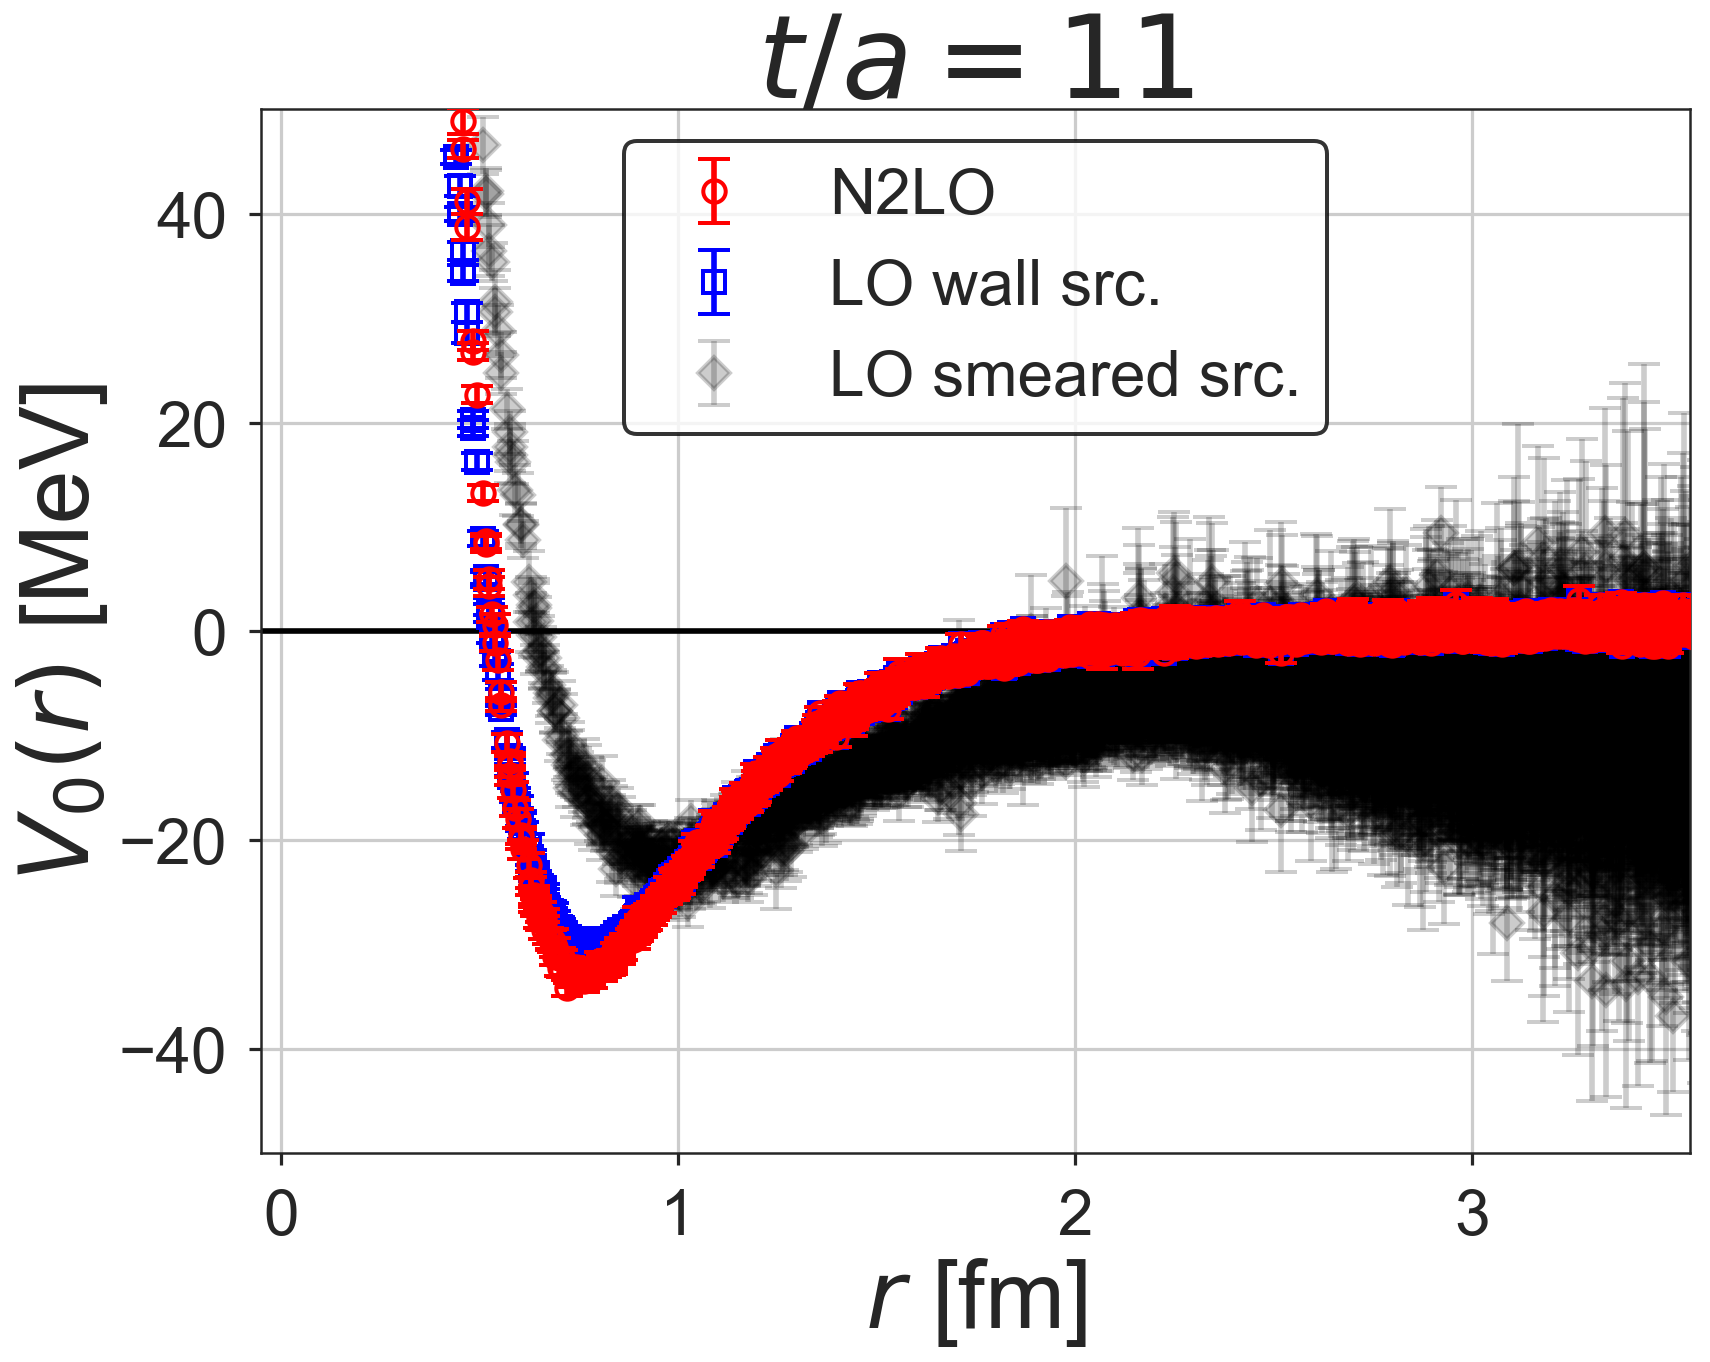

In [15]:
it = 11

fig, ax = plt.subplots()
ax.errorbar(rs * lat_unit, 
            v0_n2lo_jk[it].mean(axis=0) * ainv, 
            v0_n2lo_jk[it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
            fmt='ro', mfc='none', mec='red', mew=2.0, capsize=8, capthick=2.0,
            label='N2LO', zorder=5)

ax.errorbar(rs * lat_unit, 
            v0_lo_jk['wall'][it].mean(axis=0) * ainv, 
            v0_lo_jk['wall'][it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
            fmt='bs', mfc='none', mec='blue', mew=2.0, capsize=8, capthick=2.0,
            label='LO wall src.', zorder=3)

ax.errorbar(rs * lat_unit, 
            v0_lo_jk['exp'][it].mean(axis=0) * ainv, 
            v0_lo_jk['exp'][it].std(axis=0) * np.sqrt(bin_num - 1) * ainv,
            fmt='kD', mfc='none', mec='black', mew=2.0, capsize=8, capthick=2.0,
            label='LO smeared src.', zorder=1, alpha=0.2)

ax.set_title(f'$t/a = {it}$', size=58)
ax.set_ylim(-50, 50)
ax.set_xlim(-0.05, 3.55)
ax.axhline(0, color='black')
ax.set_ylabel(r'$V_0(r)$ [MeV]', size=48)
ax.set_xlabel(r'$r$ [fm]', size=48)

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

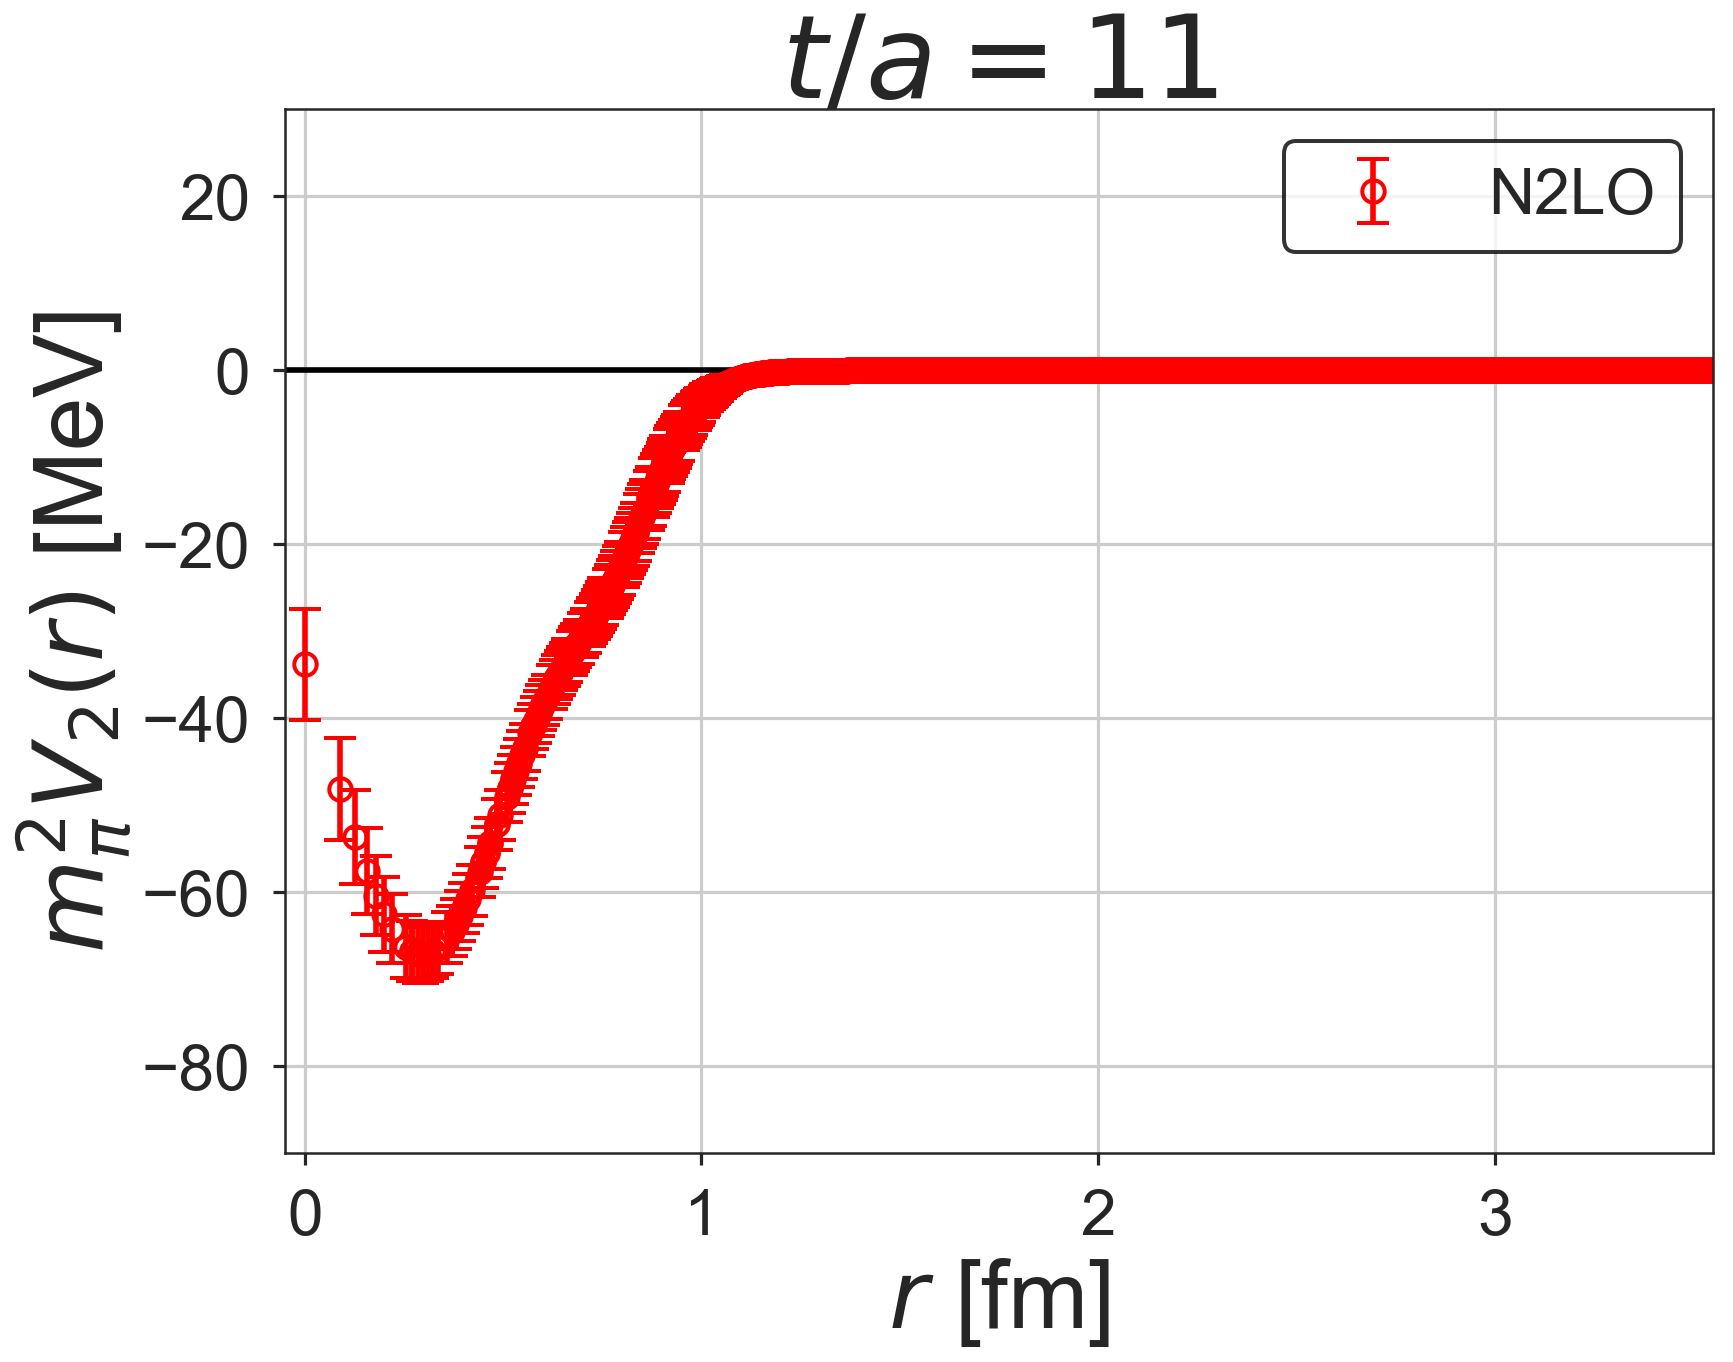

In [16]:
it = 11

fig, ax = plt.subplots()
ax.errorbar(rs * lat_unit, 
            v2_n2lo_jk[it].mean(axis=0) * mpi**2 * ainv, 
            v2_n2lo_jk[it].std(axis=0) * np.sqrt(bin_num - 1) * mpi**2 * ainv,
            fmt='ro', mfc='none', mec='red', mew=2.0, capsize=8, capthick=2.0,
            label='N2LO')

ax.set_title(f'$t/a = {it}$', size=58)
ax.set_ylim(-90, 30)
ax.set_xlim(-0.05, 3.55)
ax.axhline(0, color='black')
ax.set_ylabel(r'$m_\pi^2 V_2(r)$ [MeV]', size=48)
ax.set_xlabel(r'$r$ [fm]', size=48)

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# fitting

In [17]:
def pot_fit(xs, ys, yerrs, vfit, p0, rmax=3.5/lat_unit, rmin=0.0):
    """
    xs : r
    ys : potential 
    yerrs : error of potential
    vfit : fit function
    p0 : initial parameter
    """
    mask = (xs >= rmin) & (xs <= rmax)
    errf = lambda p, y, x, err : (vfit(p,x) - y)/err
    
    pfit = scipy.optimize.leastsq(errf, p0, args=(ys[mask], xs[mask], yerrs[mask]),
                                 full_output=True)
    dof = len(xs[mask]) - len(p0)
    chisq = sum(pfit[2]['fvec']**2)
    
    return pfit[0], dof, chisq

In [18]:
V4gauss = lambda p, x: (p[0]*np.exp(-p[1]*x**2) + p[2]*np.exp(-p[3]*x**2)
                        + p[4]*np.exp(-p[5]*x**2) + p[6]*np.exp(-p[7]*x**2))
                        
V2gauss = lambda p, x: p[0]*np.exp(-p[1]*(x-p[2])**2) + p[3]*np.exp(-p[4]*(x-p[5])**2)

In [19]:
def v2_pot_2gauss_fit(pot_jk):
    xs = rs
    ys = pot_jk.mean(axis=0)
    yerrs = pot_jk.std(axis=0) * np.sqrt(bin_num)
    p0_ini = np.array([-4.9e-1, 1.1e-1, 2.6e0, -1.5e-1, 2.0e-1, 6.8e0])
    p0, dof, chisq = pot_fit(xs, ys, yerrs, V2gauss, p0_ini)
#    print(f'av chisq/dof = {chisq/dof:3.2f}')
    prm_2gauss_av = p0
    prm_tmps = []
    for ibin in range(bin_num):
        ys = pot_jk[ibin,:]
        prm_tmp, dof, chisq = pot_fit(xs, ys, yerrs, V2gauss, p0, rmax=1.5/lat_unit)
        prm_tmps.append(prm_tmp)
#        print(f'{ibin} chisq/dof = {chisq/dof:3.2f}')

    prm_2gauss_jk = np.array(prm_tmps)
        
    return prm_2gauss_av, prm_2gauss_jk

prm_v2_2gauss_avs = {}
prm_v2_2gauss_jks = {}
for it in [11, 12, 13, 14]:
    prm_v2_2gauss_avs[it], prm_v2_2gauss_jks[it] = v2_pot_2gauss_fit(v2_n2lo_jk[it])

In [20]:
it = 11
print('V2(r) fitting parameter')
for ith in range(6):
    print('{} {:+4.4f} +- {:+4.4f}'.format(ith, prm_v2_2gauss_avs[it][ith],
                                        prm_v2_2gauss_jks[it][:,ith].std() * np.sqrt(bin_num - 1)))

V2(r) fitting parameter
0 -0.5689 +- +0.0272
1 +0.0616 +- +0.0105
2 +3.2306 +- +0.1790
3 -0.1128 +- +0.0214
4 +0.2496 +- +0.0443
5 +8.4834 +- +0.4071


In [21]:
p0_V4gauss = np.array([ 0.84479193,  0.80043474,
               0.28222412,  0.20486377,
               0.16196509,  0.06677487,
              -0.03015106,  0.00911472])

def pot_4gauss_fit(pot_jk):
    xs = rs
    ys = pot_jk.mean(axis=0)
    yerrs = pot_jk.std(axis=0) * np.sqrt(bin_num)
    p0, dof, chisq = pot_fit(xs, ys, yerrs, V4gauss, p0_V4gauss)
#    print(f'av chisq/dof = {chisq/dof:3.2f}')
    prm_4gauss_av = p0
    prm_tmps = []
    for ibin in range(bin_num):
        ys = pot_jk[ibin,:]
        prm_tmp, dof, chisq = pot_fit(xs, ys, yerrs, V4gauss, p0)
        prm_tmps.append(prm_tmp)
#        print(f'{ibin} chisq/dof = {chisq/dof:3.2f}')

    prm_4gauss_jk = np.array(prm_tmps)
        
    return prm_4gauss_av, prm_4gauss_jk

In [22]:
prm_v0_4gauss_avs = {}
prm_v0_4gauss_jks = {}

In [23]:
for it in [11, 12, 13, 14]:
    print(f'# t = {it}')
    prm_v0_4gauss_avs[('n2lo', it)], prm_v0_4gauss_jks[('n2lo', it)] = pot_4gauss_fit(v0_n2lo_jk[it])

# t = 11
# t = 12
# t = 13
# t = 14


In [24]:
for it in [11, 12, 13, 14]:
    print(f'# t = {it}')
    prm_v0_4gauss_avs[('wall', it)], prm_v0_4gauss_jks[('wall', it)] = pot_4gauss_fit(v0_lo_jk['wall'][it])

# t = 11
# t = 12
# t = 13
# t = 14


In [25]:
it = 11
print('V0(r) N2LO fitting parameter')
for ith in range(8):
    print('{} {:+4.4f} +- {:+4.4f}'.format(ith, prm_v0_4gauss_avs[('n2lo', it)][ith],
                        prm_v0_4gauss_jks[('n2lo', it)][:,ith].std() * np.sqrt(bin_num - 1)))

V0(r) N2LO fitting parameter
0 +1.2805 +- +0.0427
1 +0.8697 +- +0.0501
2 +0.4331 +- +0.0195
3 +0.1916 +- +0.0206
4 +0.2465 +- +0.0315
5 +0.0670 +- +0.0044
6 -0.0313 +- +0.0018
7 +0.0086 +- +0.0004


In [26]:
it = 11
print('V0(r) LO(wall) fitting parameter')
for ith in range(8):
    print('{} {:+4.4f} +- {:+4.4f}'.format(ith, prm_v0_4gauss_avs[('wall', it)][ith],
                        prm_v0_4gauss_jks[('wall', it)][:,ith].std() * np.sqrt(bin_num - 1)))

V0(r) LO(wall) fitting parameter
0 +1.0481 +- +0.0134
1 +1.1348 +- +0.0148
2 +0.4640 +- +0.0037
3 +0.2538 +- +0.0104
4 +0.2066 +- +0.0090
5 +0.0634 +- +0.0025
6 -0.0296 +- +0.0015
7 +0.0083 +- +0.0004


# check fitting curve

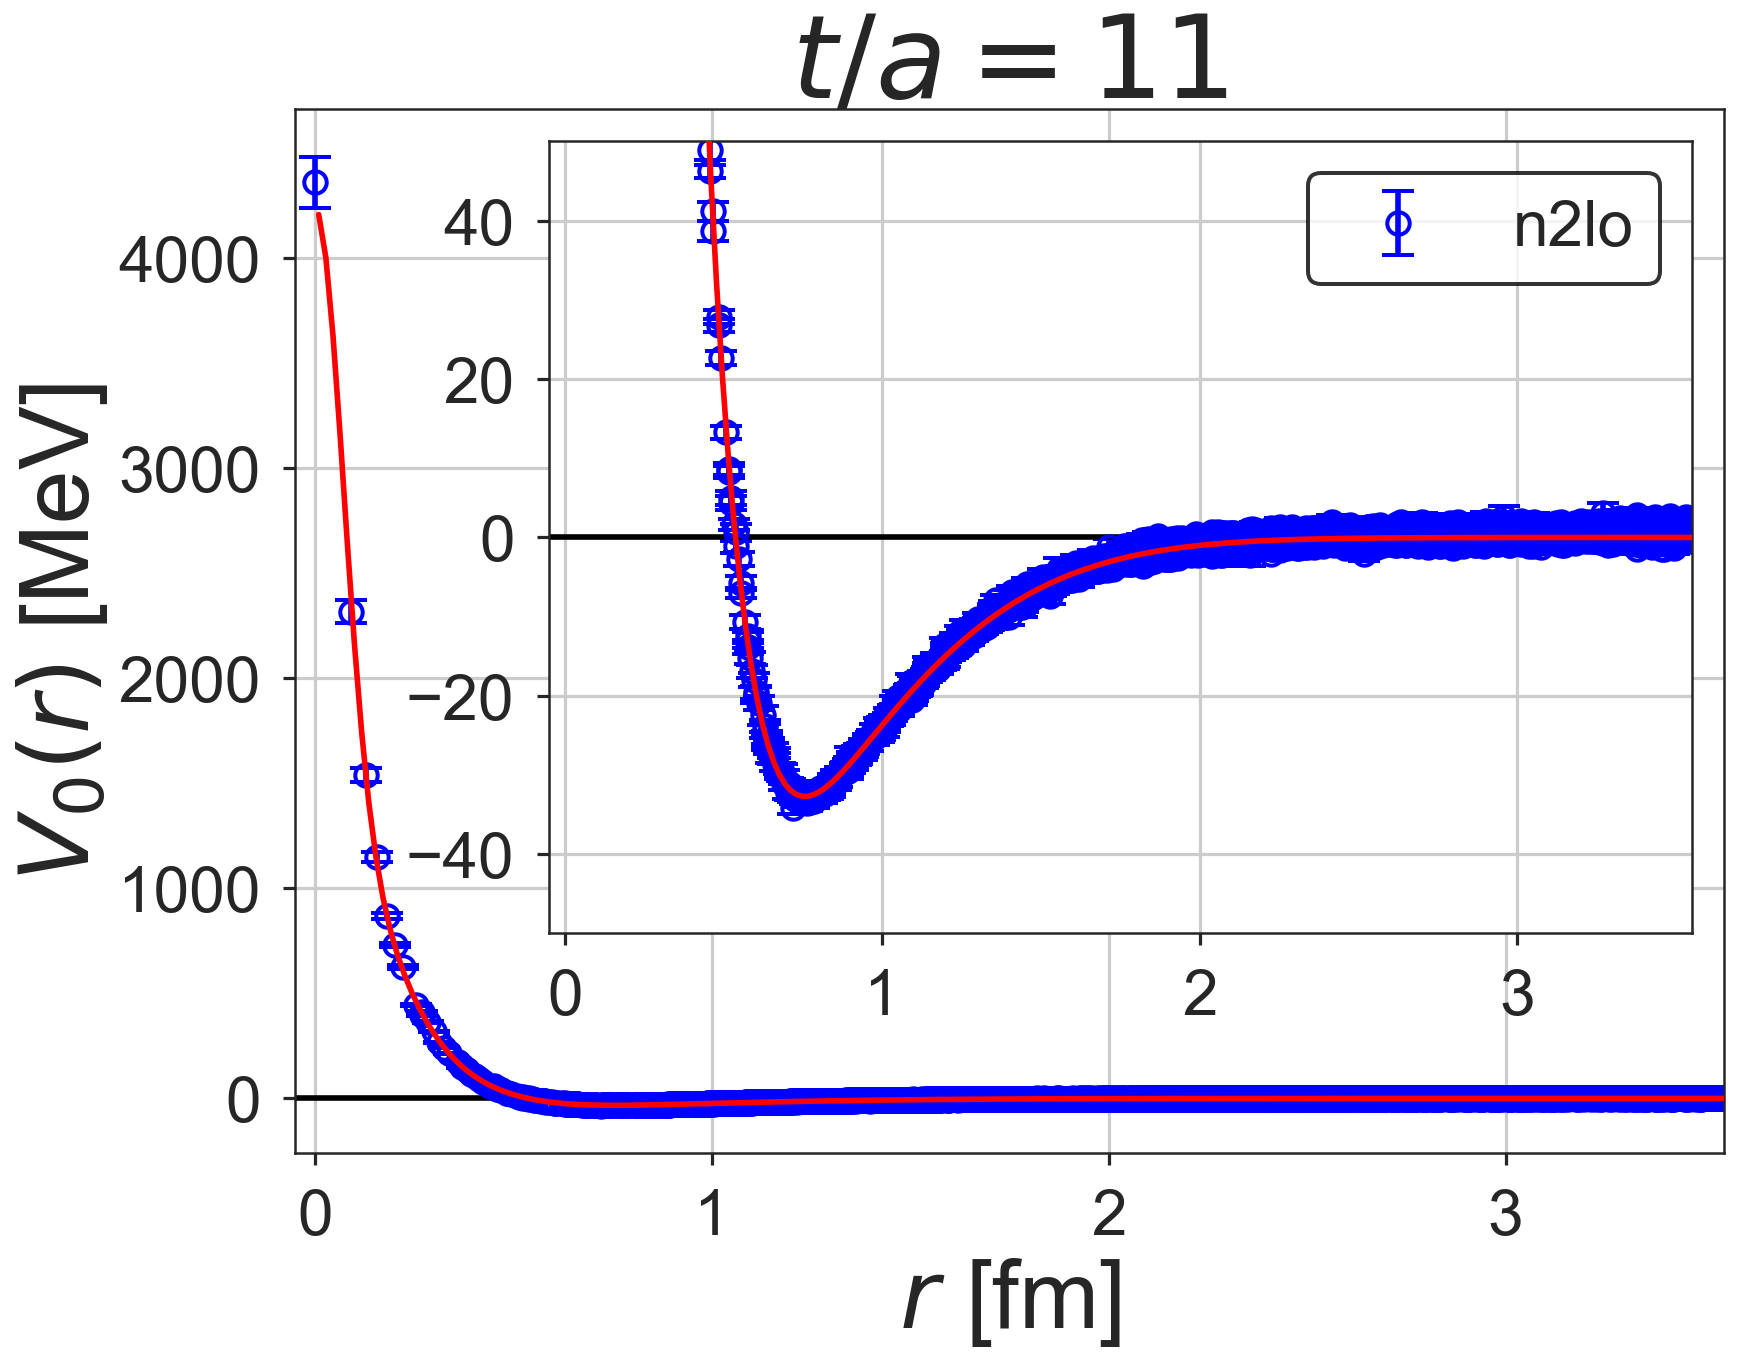

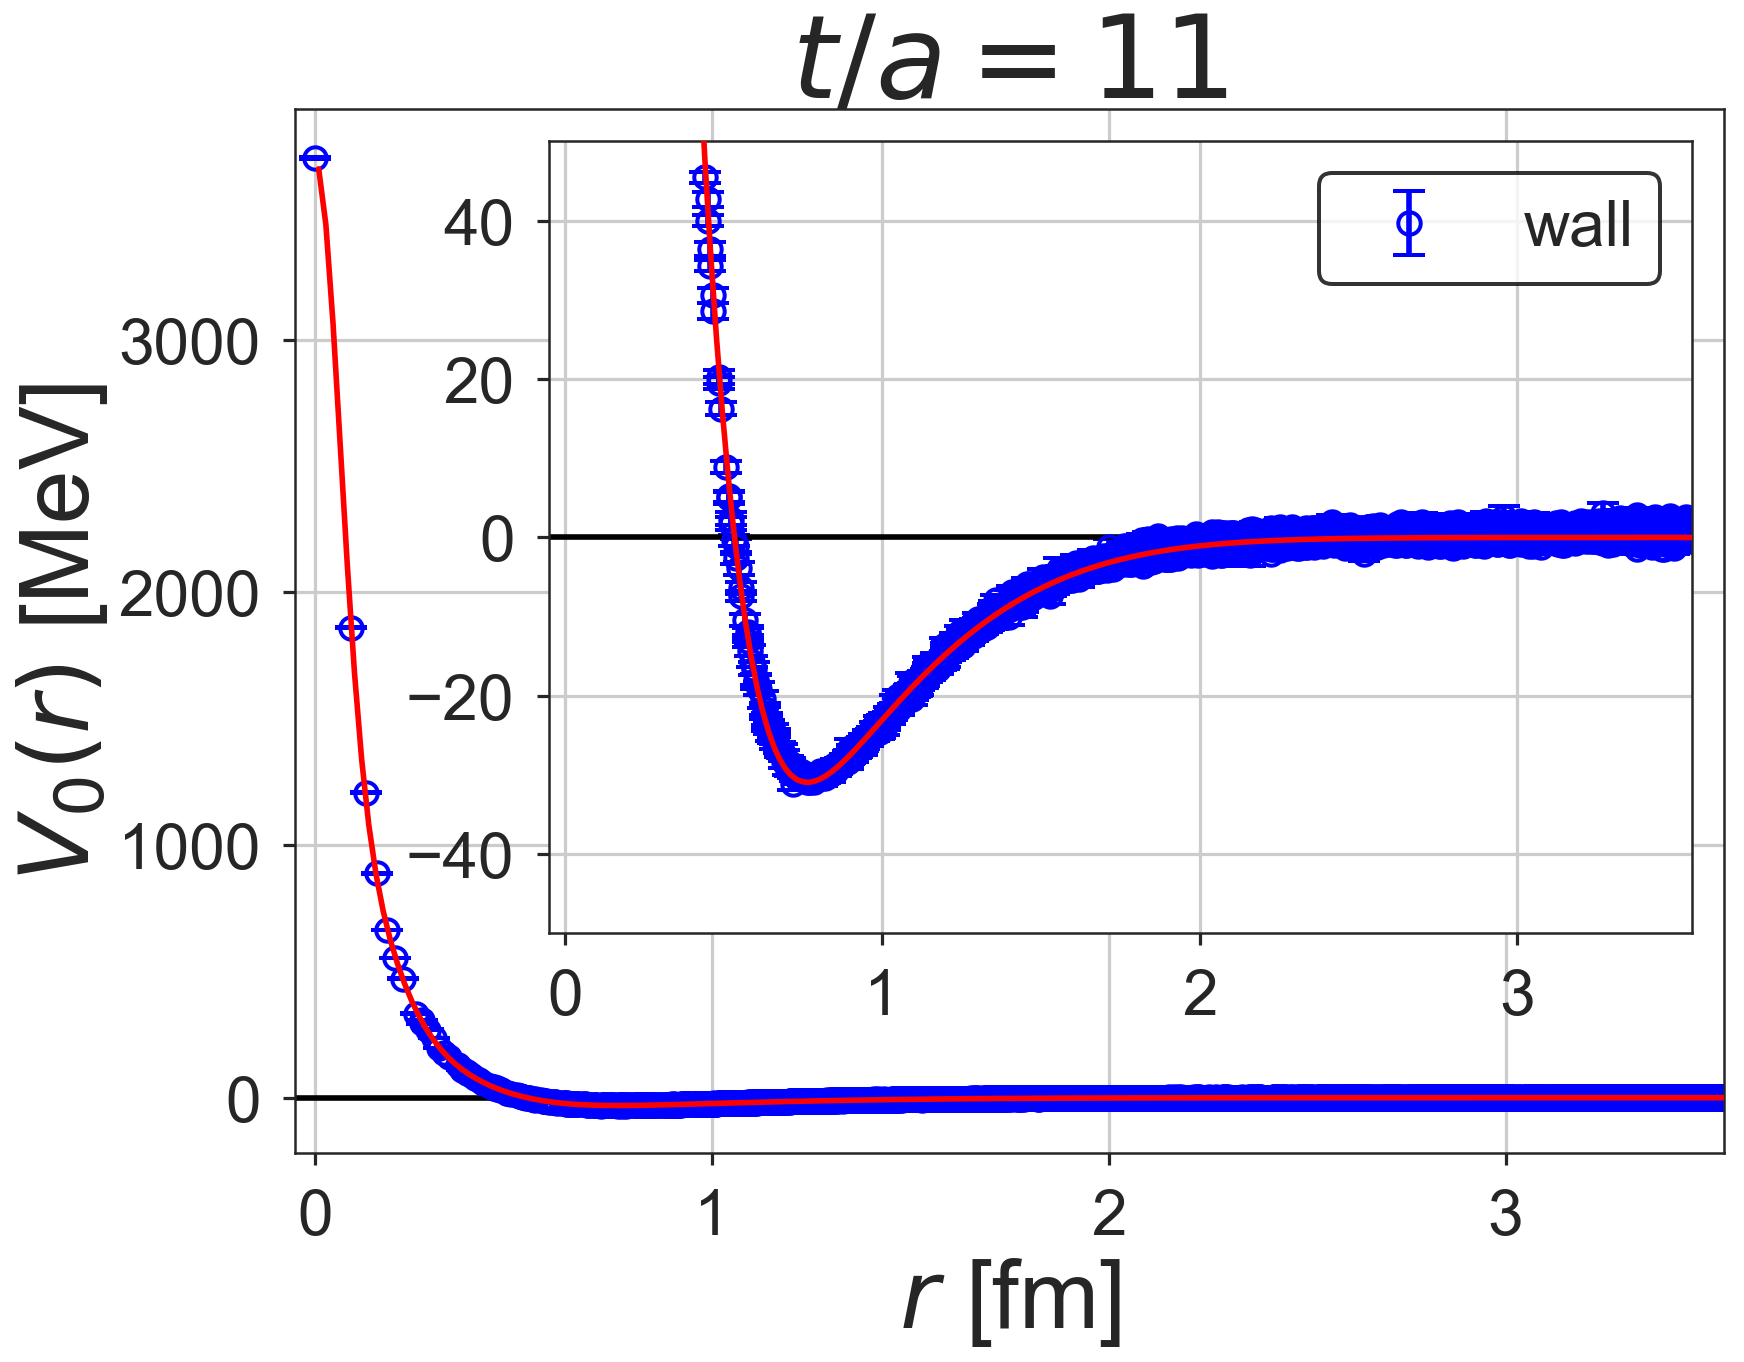

In [27]:
def check_v0_fitting(pot_jk, src, it):
    fig, ax = plt.subplots()
    
    axin = inset_axes(ax, width='80%', height=5.5, loc=1)
    p0 = prm_v0_4gauss_avs[(src, it)]
    xls = np.linspace(1.0e-1, 40, 200)
    for _ax in [ax, axin]:
        _ax.errorbar(rs * lat_unit, 
                pot_jk.mean(axis=0) * ainv, 
                pot_jk.std(axis=0) * np.sqrt(bin_num - 1) * ainv,
                fmt='bo', mfc='none', mec='blue', mew=2.0, capsize=8, capthick=2.0,
                label=f'{src}')
        _ax.plot(xls * lat_unit, V4gauss(p0,xls) * ainv, color='red', zorder=5) 
        _ax.axhline(0, color='black')
        _ax.set_xlim(-0.05, 3.55)

#    for ibin in range(bin_num):
#        p0 = prm_v0_4gauss_jks[(src, it)][ibin,:]
#        ax.plot(xls * lat_unit, V4gauss(p0,xls) * ainv, zorder=5) 

    ax.set_title(f'$t/a = {it}$', size=58)
    axin.set_ylim(-50, 50)
    ax.set_ylabel(r'$V_0(r)$ [MeV]', size=48)
    ax.set_xlabel(r'$r$ [fm]', size=48)
    
    leg = axin.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    
for it in [11]: #, 14, 15, 16]:
    check_v0_fitting(v0_n2lo_jk[it], 'n2lo', it)
    check_v0_fitting(v0_lo_jk['wall'][it], 'wall', it)

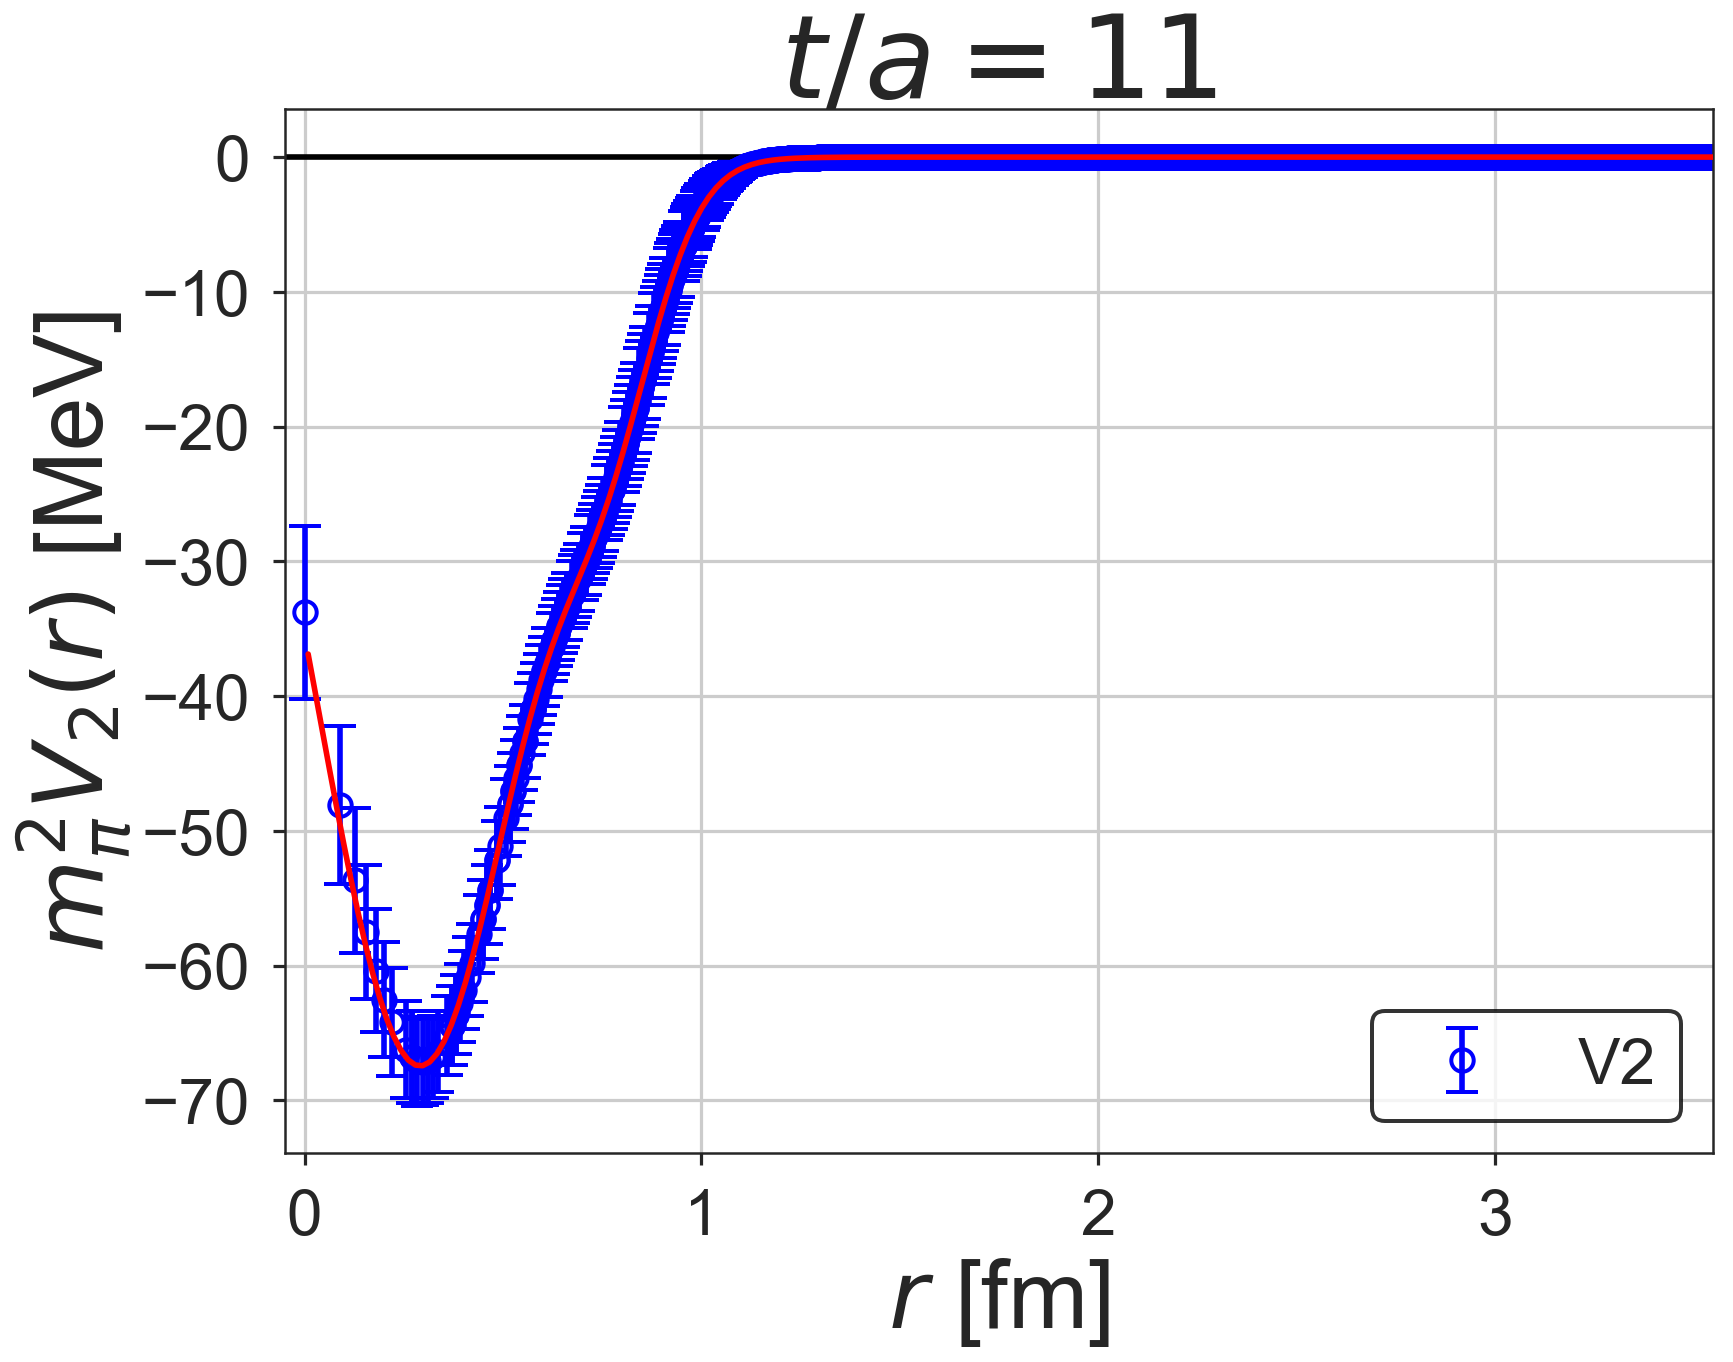

In [28]:
def check_v2_fitting(pot_jk, it):
    fig, ax = plt.subplots()
    
    p0 = prm_v2_2gauss_avs[it]
    xls = np.linspace(1.0e-1, 40, 200)
    ax.errorbar(rs * lat_unit, 
                pot_jk.mean(axis=0) * mpi**2 * ainv, 
                pot_jk.std(axis=0) * np.sqrt(bin_num - 1) * mpi**2 * ainv,
                fmt='bo', mfc='none', mec='blue', mew=2.0, capsize=8, capthick=2.0,
                label=f'V2')
    ax.plot(xls * lat_unit, V2gauss(p0,xls) * mpi**2 * ainv, color='red', zorder=5) 
    ax.axhline(0, color='black')
    ax.set_xlim(-0.05, 3.55)

    ax.set_title(f'$t/a = {it}$', size=58)
    ax.set_ylabel(r'$m_\pi^2 V_2(r)$ [MeV]', size=48)
    ax.set_xlabel(r'$r$ [fm]', size=48)
    
    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    
for it in [11]:
    check_v2_fitting(v2_n2lo_jk[it], it)

In [29]:
with open('pkls/v0_4gauss_func_prm_av_jk.pkl', 'wb') as fout:
    pickle.dump((prm_v0_4gauss_avs, prm_v0_4gauss_jks), fout)
#with open('pkls/v0_4gauss_func_prm_av_jk.pkl', 'rb') as fin:
#    prm_v0_4gauss_avs, prm_v0_4gauss_jks = pickle.load(fin)

In [30]:
with open('pkls/v2_2gauss_func_prm_av_jk.pkl', 'wb') as fout:
    pickle.dump((prm_v2_2gauss_avs, prm_v2_2gauss_jks), fout)

#with open('pkls/v2_2gauss_func_prm_av_jk.pkl', 'rb') as fin:
#    prm_v2_2gauss_avs, prm_v2_2gauss_jks = pickle.load(fin)

# scattering phase shifts



In [31]:
class Schroedinger_Eq(object):
    """Calculate the scattering phase shifts by solving Schroedinger Eq.
    
    All parameters are in lattice unit.
    """
    def __init__(self, pot, red_mass, r_min = 1.0e-3, r_max = 1.0e2, r_diff = 1.0e-4):
        self.pot = pot
        self.rs = np.arange(r_min, r_max, r_diff)
        self.red_mass = red_mass
        
    def sch_eq(self, uv, r, k2):
        """
        u = psi(r)/r with u(0) = 0
        solve
        u'' = - 2 mu (E - V(r)) u
        -->
        u' = v
        v' = - (k^2 - 2 mu V(r)) u
        """
        du = uv[1]
        dv = - (k2 - 2 * self.red_mass * self.pot(r)) * uv[0]
        return np.array([du, dv])
        
    def conv_delta(self, r, u, u_prime, k):
        return np.mod(np.arctan(k*u/u_prime) - k*r, np.pi)
    
    def plot_asymptotic_behavior(self, k2, u_prime_ini=1.0e-4):
        """
        This method checks convergence of the phase shift.
        """
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))
        fig, ax = plt.subplots()
        ax.plot(self.rs, self.conv_delta(self.rs, trj[:,0], trj[:,1], np.sqrt(k2)),
               label=r'$k^2 = {}$'.format(k2))
        ax.set_xlabel(r'$r$', size=48)
        ax.set_ylabel(r'$\delta$ [rad.]', size=48)
        leg = ax.legend(frameon=True)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        return ax
        
    def calc_phase_shift(self, k2, u_prime_ini=1.0e-4):
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))

        return self.conv_delta(self.rs[-1], trj[-1,0], trj[-1,1], np.sqrt(k2))                                

In [32]:
class Schroedinger_Eq_with_V2(Schroedinger_Eq):
    """Calculate the scattering phase shifts by solving Schroedinger Eq.
    
    All parameters are in lattice unit.
    """
    def __init__(self, pot, pot2, red_mass, r_min = 1.0e-3, r_max = 1.0e2, r_diff = 1.0e-4):
        self.pot = pot
        self.pot2 = pot2
        self.rs = np.arange(r_min, r_max, r_diff)
        self.red_mass = red_mass
        
    def sch_eq(self, uv, r, k2):
        """
        u = psi(r)/r with u(0) = 0
        solve
        u'' = - 2 mu (E - V(r)) u
        -->
        u' = v
        v' = - (k^2 - 2 mu V(r)) u
        """
        du = uv[1]
        dv = - (k2 - 2 * self.red_mass * self.pot(r)) / (1 - 2.0 * self.red_mass * self.pot2(r)) * uv[0]
        return np.array([du, dv])                             

In [33]:
# test

k2s = np.linspace(1.0e-5, 3.2e-2, 100)
p0 = prm_v0_4gauss_avs[('wall', 11)]
pot = lambda r: V4gauss(p0, r)
scheq = Schroedinger_Eq(pot, 0.5 * mn)
deltas = np.array([scheq.calc_phase_shift(k2) for k2 in k2s])

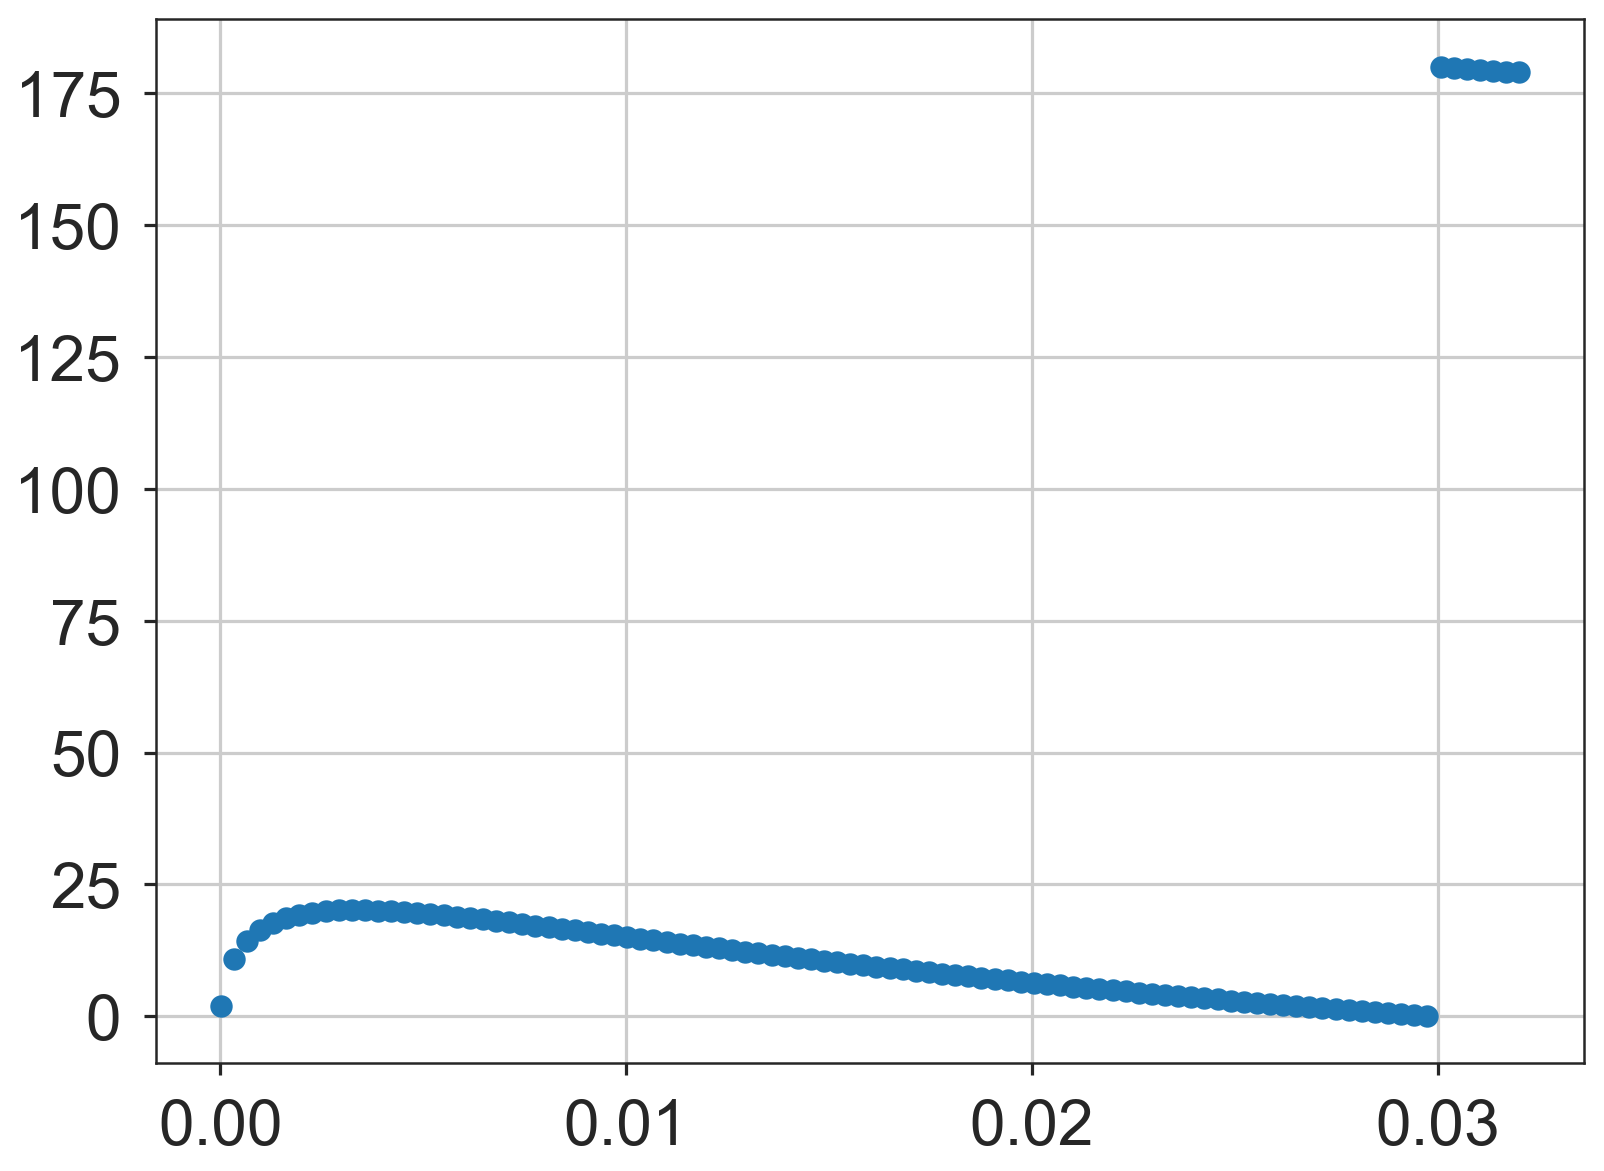

In [34]:
fig, ax = plt.subplots()
ax.plot(k2s, np.rad2deg(deltas), 'o')

In [35]:
def calc_scattering_phase_shifts_v0(src, it):
    k2s = np.linspace(1.0e-10, 3.2e-2, 100)
    deltas_jk = []
    for ibin in tqdm(range(bin_num)):
        p0 = prm_v0_4gauss_jks[(src, it)][ibin,:]
        pot = lambda r: V4gauss(p0, r)
        scheq = Schroedinger_Eq(pot, 0.5 * mn)
        deltas = np.array([scheq.calc_phase_shift(k2) for k2 in k2s])
        deltas_jk.append(deltas)

    return k2s, np.array(deltas_jk)

k2s = {}
deltas_jk = {}
for src in ['wall', 'n2lo']:
    for it in [11, 12, 13, 14]:
        k2s[(src, it)], deltas_jk[(src, it)] = calc_scattering_phase_shifts_v0(src, it)
    

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [36]:
def calc_scattering_phase_shifts_v0_v2(it):
    k2s = np.linspace(1.0e-10, 3.2e-2, 100)
    deltas_jk = []
    for ibin in tqdm(range(bin_num)):
        p0 = prm_v0_4gauss_jks[('n2lo', it)][ibin,:]
        pot = lambda r: V4gauss(p0, r)
        p2 = prm_v2_2gauss_jks[it][ibin,:]
        pot2 = lambda r: V2gauss(p2, r)
        
        scheq = Schroedinger_Eq_with_V2(pot, pot2, 0.5 * mn)
        deltas = np.array([scheq.calc_phase_shift(k2) for k2 in k2s])
        deltas_jk.append(deltas)

    return k2s, np.array(deltas_jk)

src = 'n2lo_w_v2'
for it in [11, 12, 13, 14]:
    k2s[(src, it)], deltas_jk[(src, it)] = calc_scattering_phase_shifts_v0_v2(it)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [37]:
with open('pkls/k2s_deltas_jk.pkl', 'wb') as fout:
    pickle.dump((k2s, deltas_jk), fout)

In [38]:
with open('pkls/k2s_deltas_jk.pkl', 'rb') as fin:
    k2s, deltas_jk = pickle.load(fin)

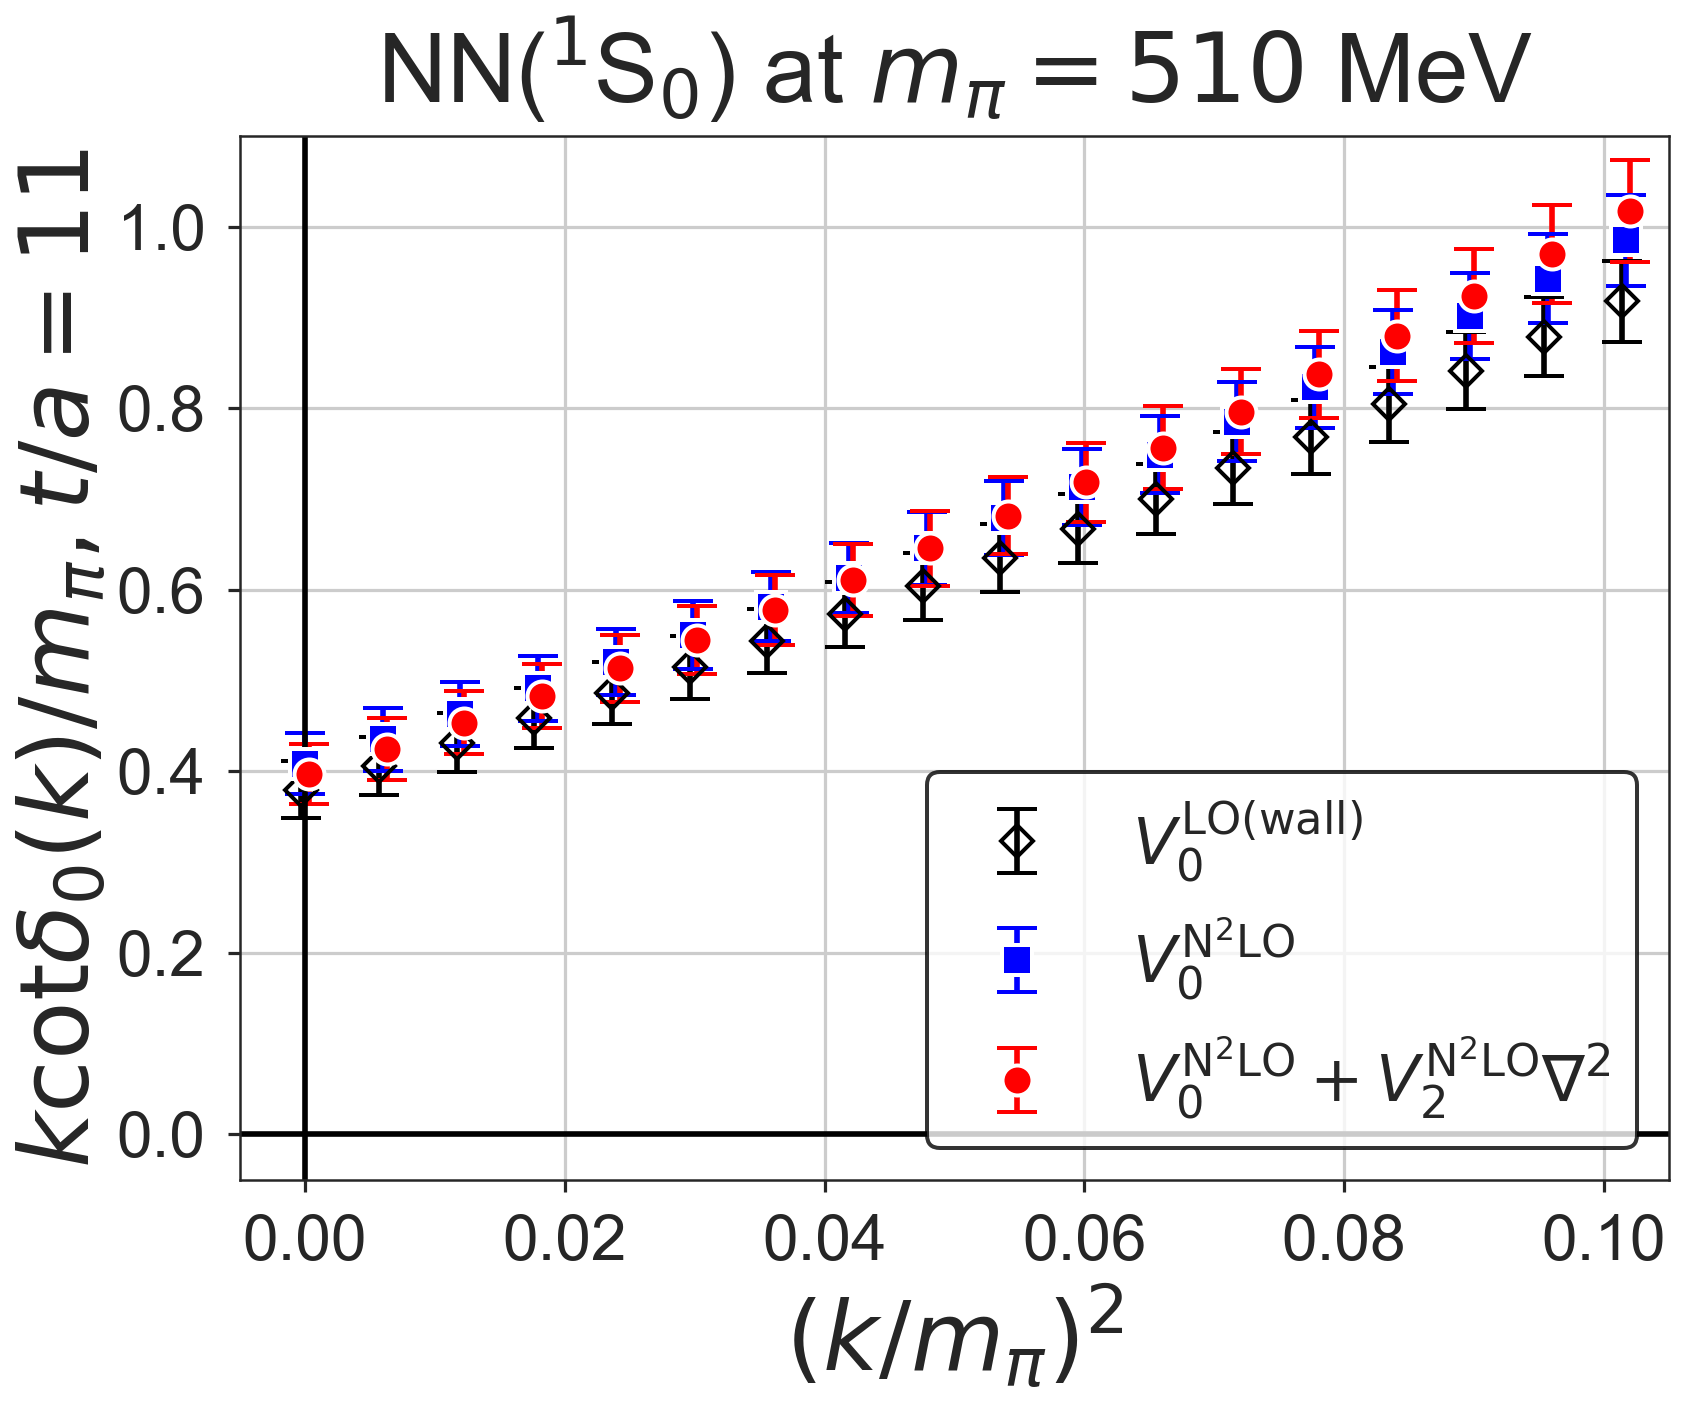

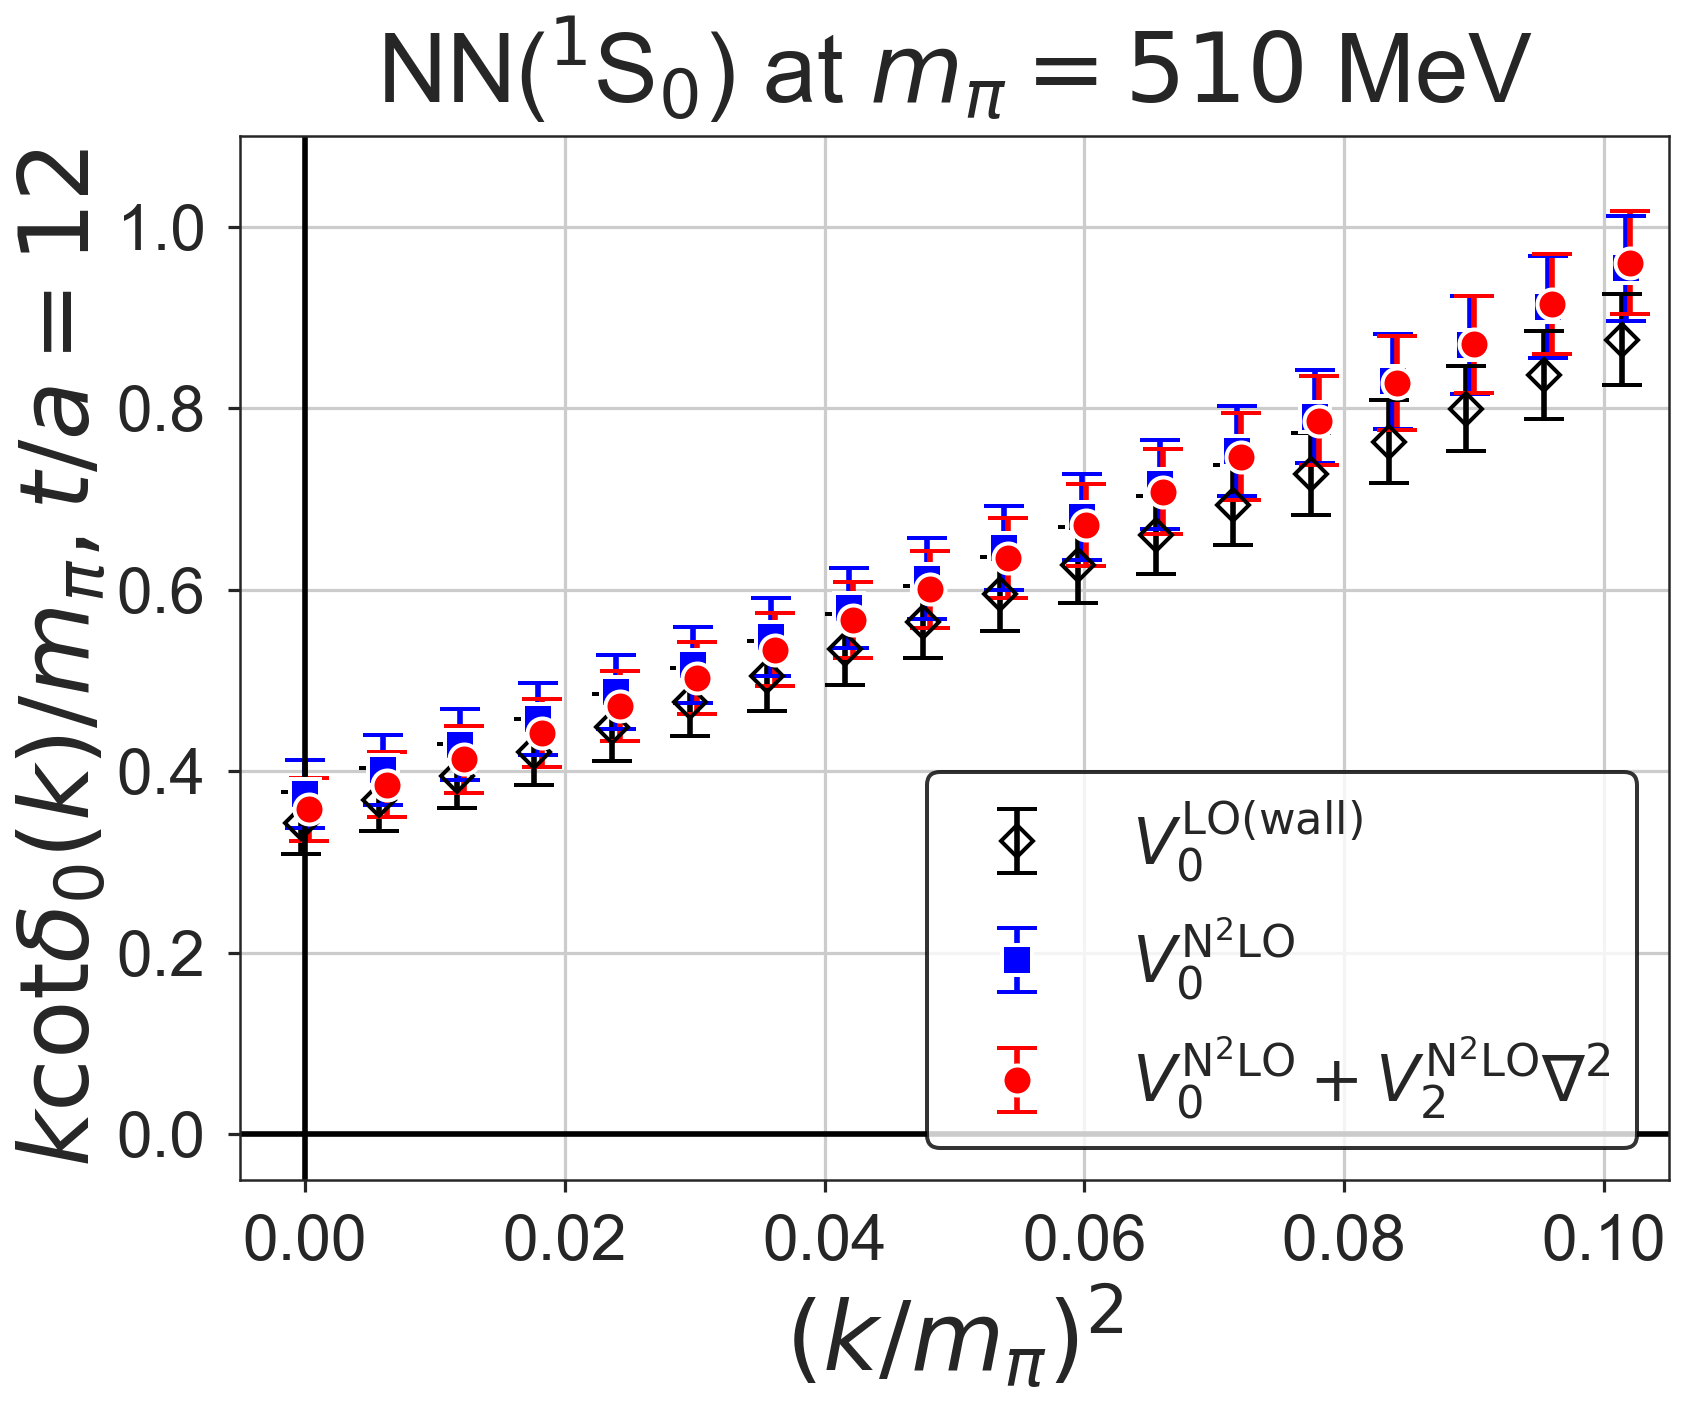

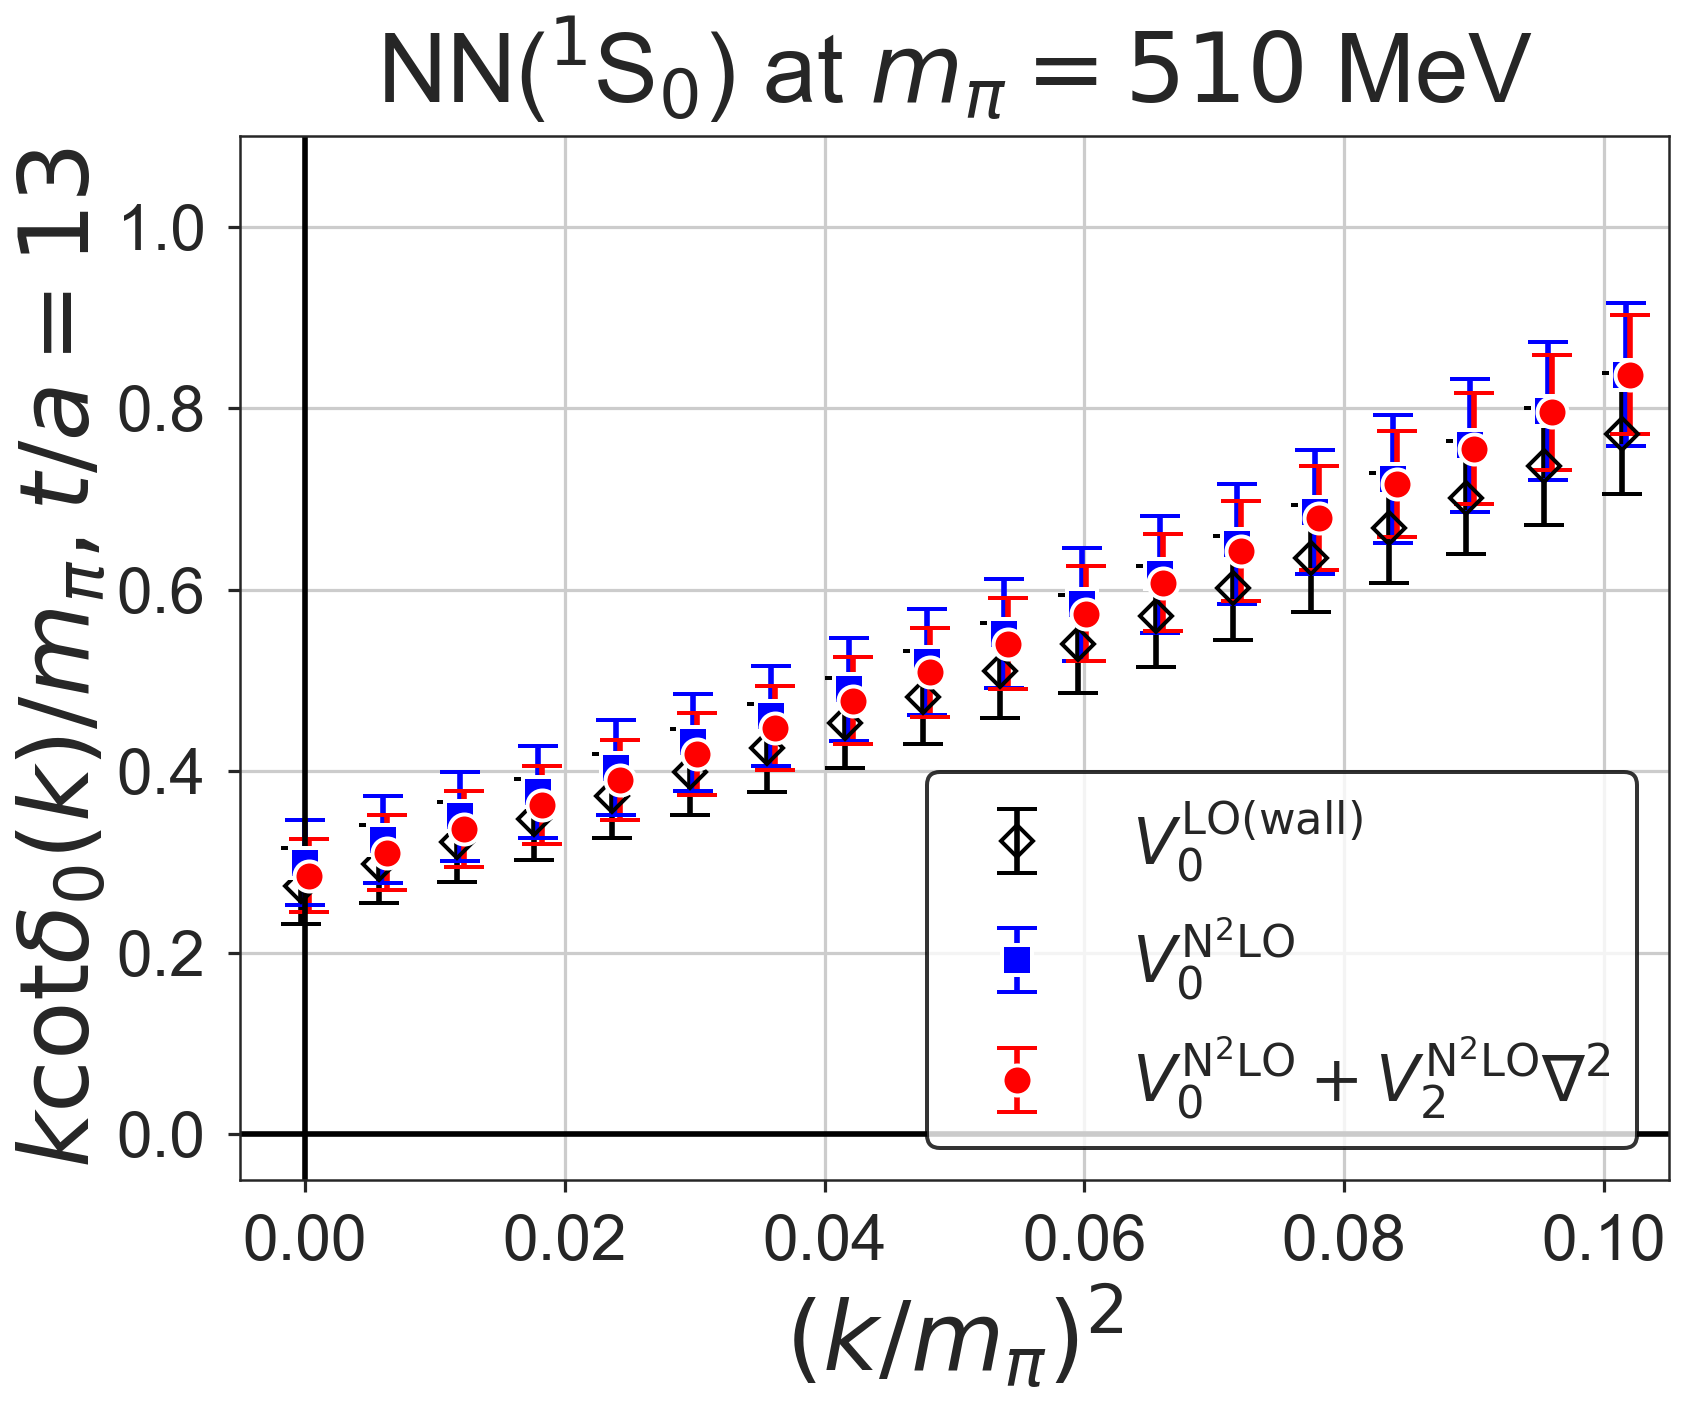

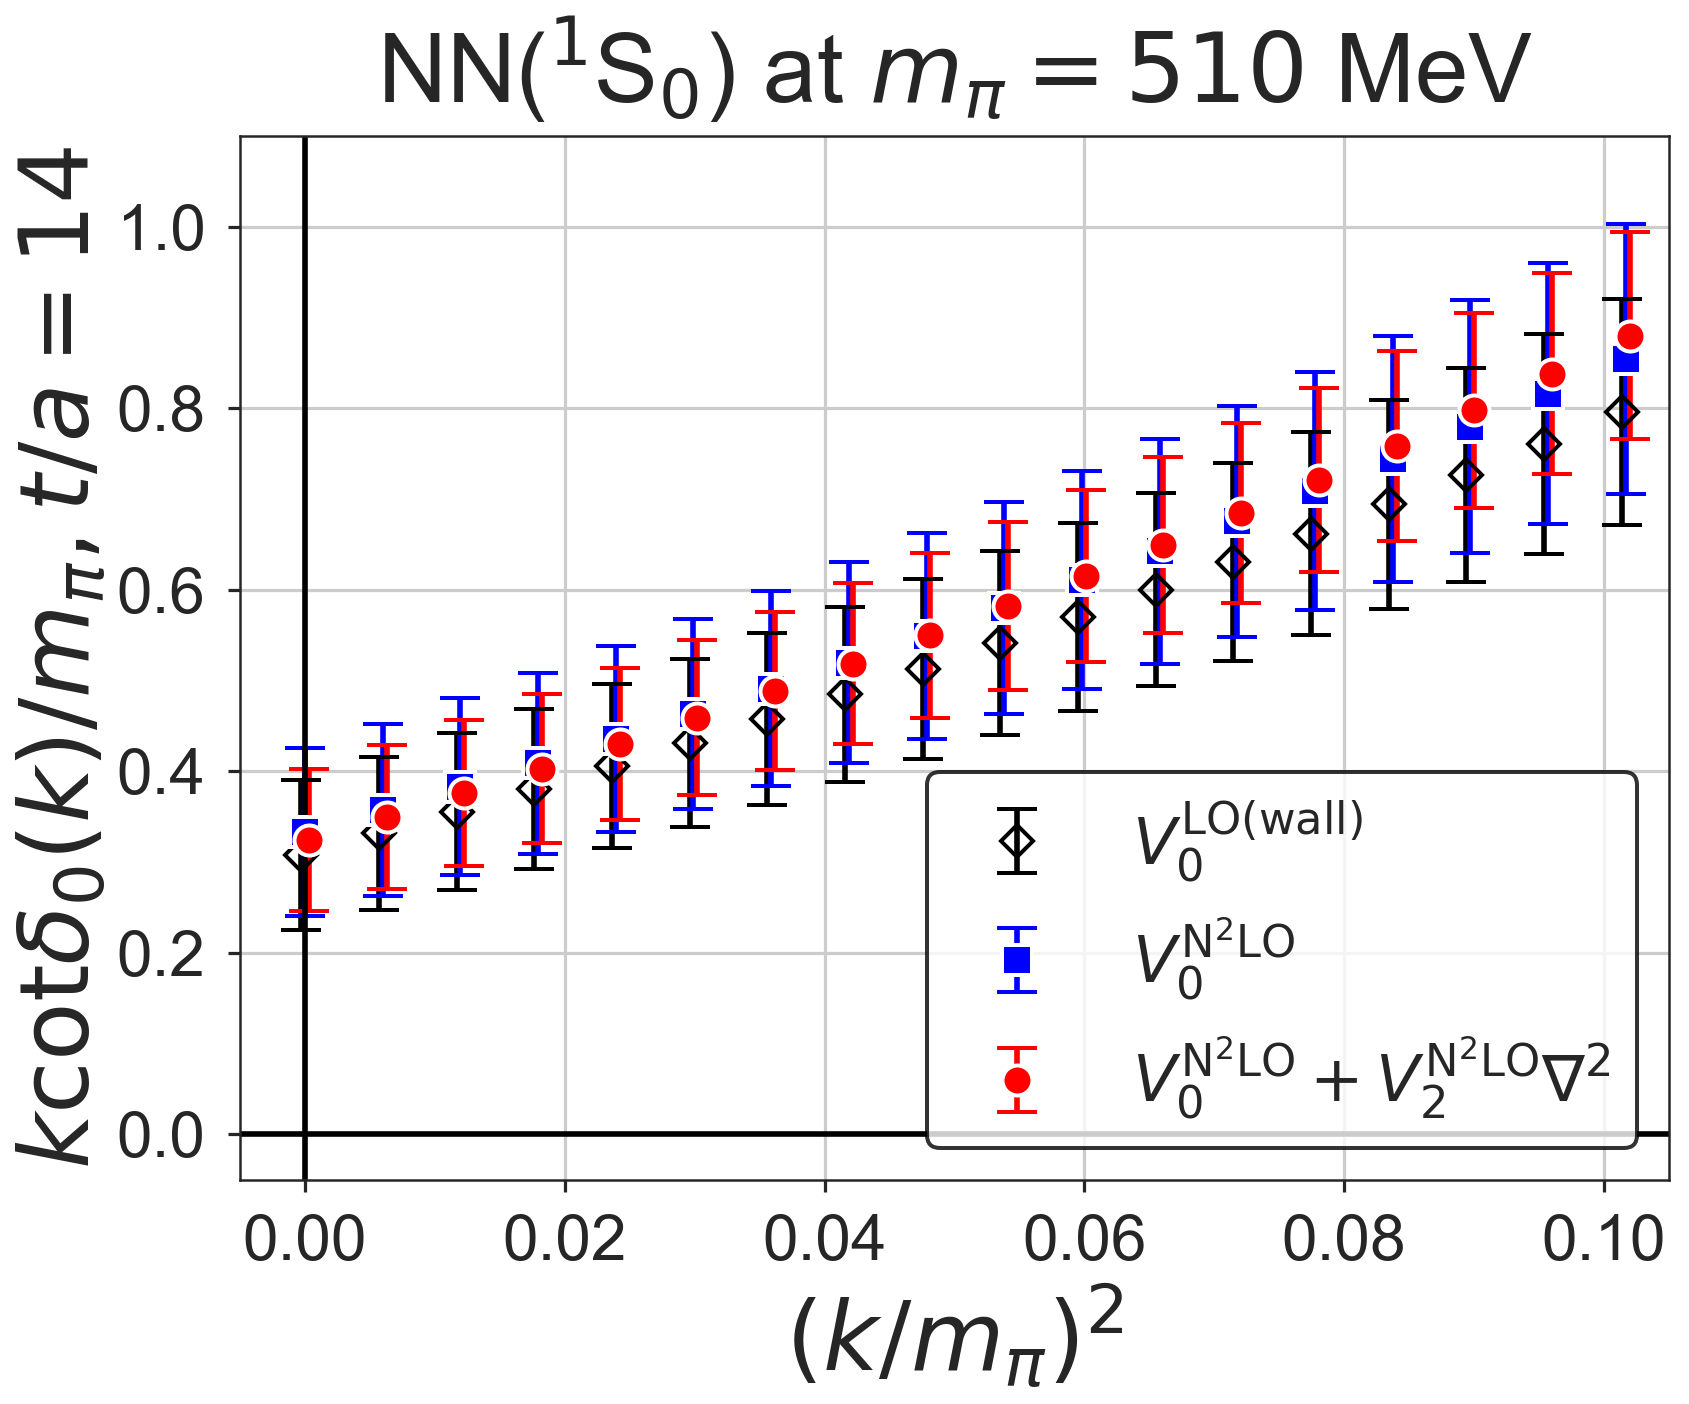

In [39]:
def plot_kcot_delta(it):
    fig, ax = plt.subplots()

    src = 'wall'
    k2 = k2s[(src, it)]
    delta_jk = deltas_jk[(src, it)]
    ax.errorbar(k2/mpi**2 - 3.0e-4, (np.sqrt(k2)/np.tan(delta_jk)).mean(axis=0)/mpi,
                (np.sqrt(k2)/np.tan(delta_jk)).std(axis=0) * np.sqrt(bin_num - 1)/mpi,
                capsize=10, capthick=2, 
                fmt='D', color='black', mfc='none', mew=2.0, label=r'$V_0^\mathrm{LO(wall)}$')

    src = 'n2lo'
    k2 = k2s[(src, it)]
    delta_jk = deltas_jk[(src, it)]
    ax.errorbar(k2/mpi**2, (np.sqrt(k2)/np.tan(delta_jk)).mean(axis=0)/mpi,
                (np.sqrt(k2)/np.tan(delta_jk)).std(axis=0) * np.sqrt(bin_num - 1)/mpi,
                capsize=10, capthick=2, ms=15, 
                fmt='s', color='blue', mec='white', mew=2.0, label=r'$V_0^\mathrm{N^2LO}$')

    src = 'n2lo_w_v2'
    k2 = k2s[(src, it)]
    delta_jk = deltas_jk[(src, it)]
    ax.errorbar(k2/mpi**2 + 3.0e-4, (np.sqrt(k2)/np.tan(delta_jk)).mean(axis=0)/mpi,
                (np.sqrt(k2)/np.tan(delta_jk)).std(axis=0) * np.sqrt(bin_num - 1)/mpi,
                capsize=10, capthick=2, ms=15, 
                fmt='o', color='red', mec='white', mew=2.0, label=r'$V_0^\mathrm{N^2LO} + V_2^\mathrm{N^2LO}\nabla^2$')

    ax.set_xlim(-0.005, 0.105)
    ax.set_ylim(-0.05, 1.1)
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
    ax.set_ylabel(r'$k\cot\delta_0(k)/m_\pi, t/a = {}$'.format(it), size=48)
    leg = ax.legend(loc='lower right', frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    ax.set_title(r'NN($^1$S$_0$) at $m_\pi = 510$ MeV', size=48, y=1.02)

    fig.savefig('../figs/nn1s0_kcot_delta_t{:03d}.pdf'.format(it),
                bbox_inches='tight')
    
for it in [11, 12, 13, 14]:
    plot_kcot_delta(it)

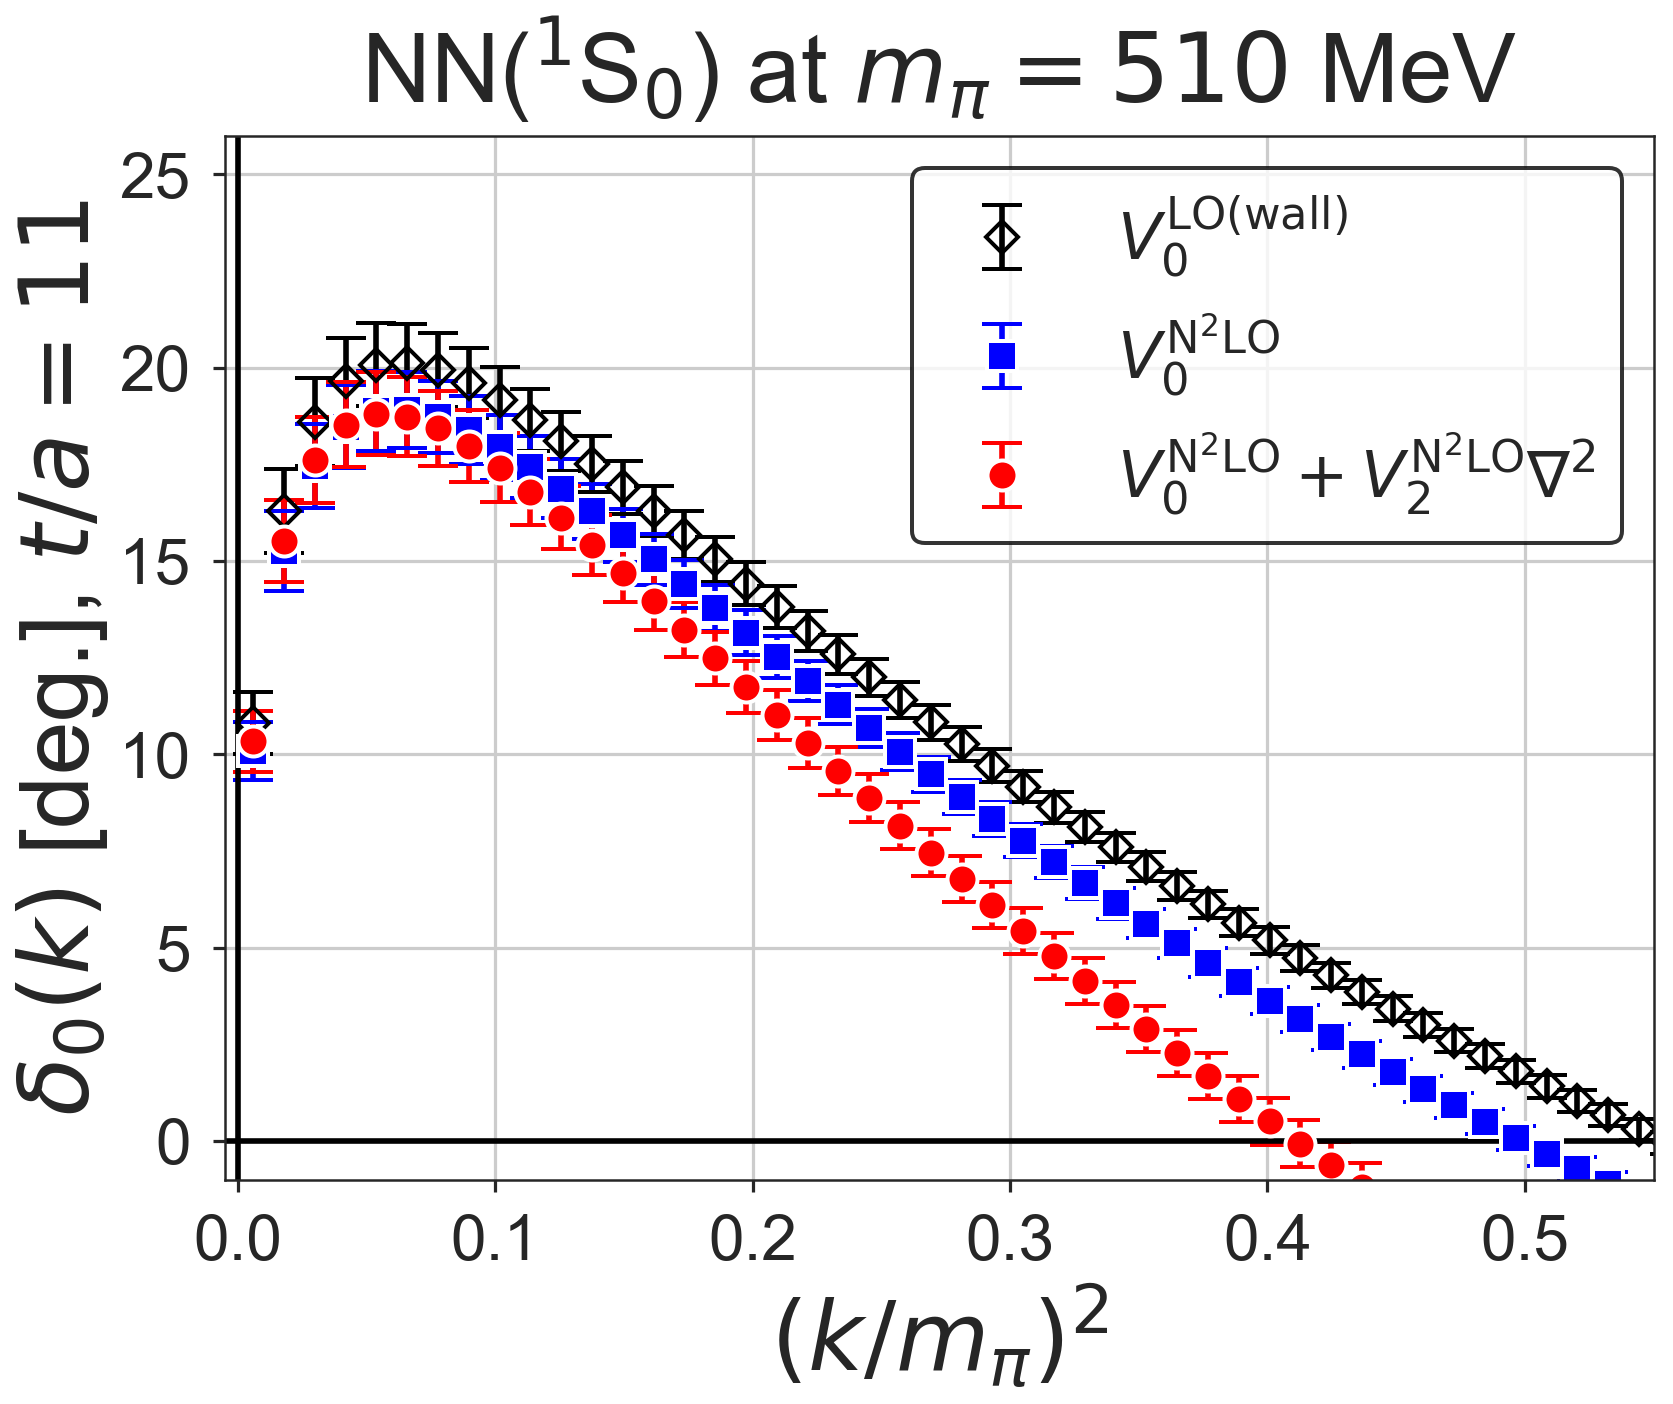

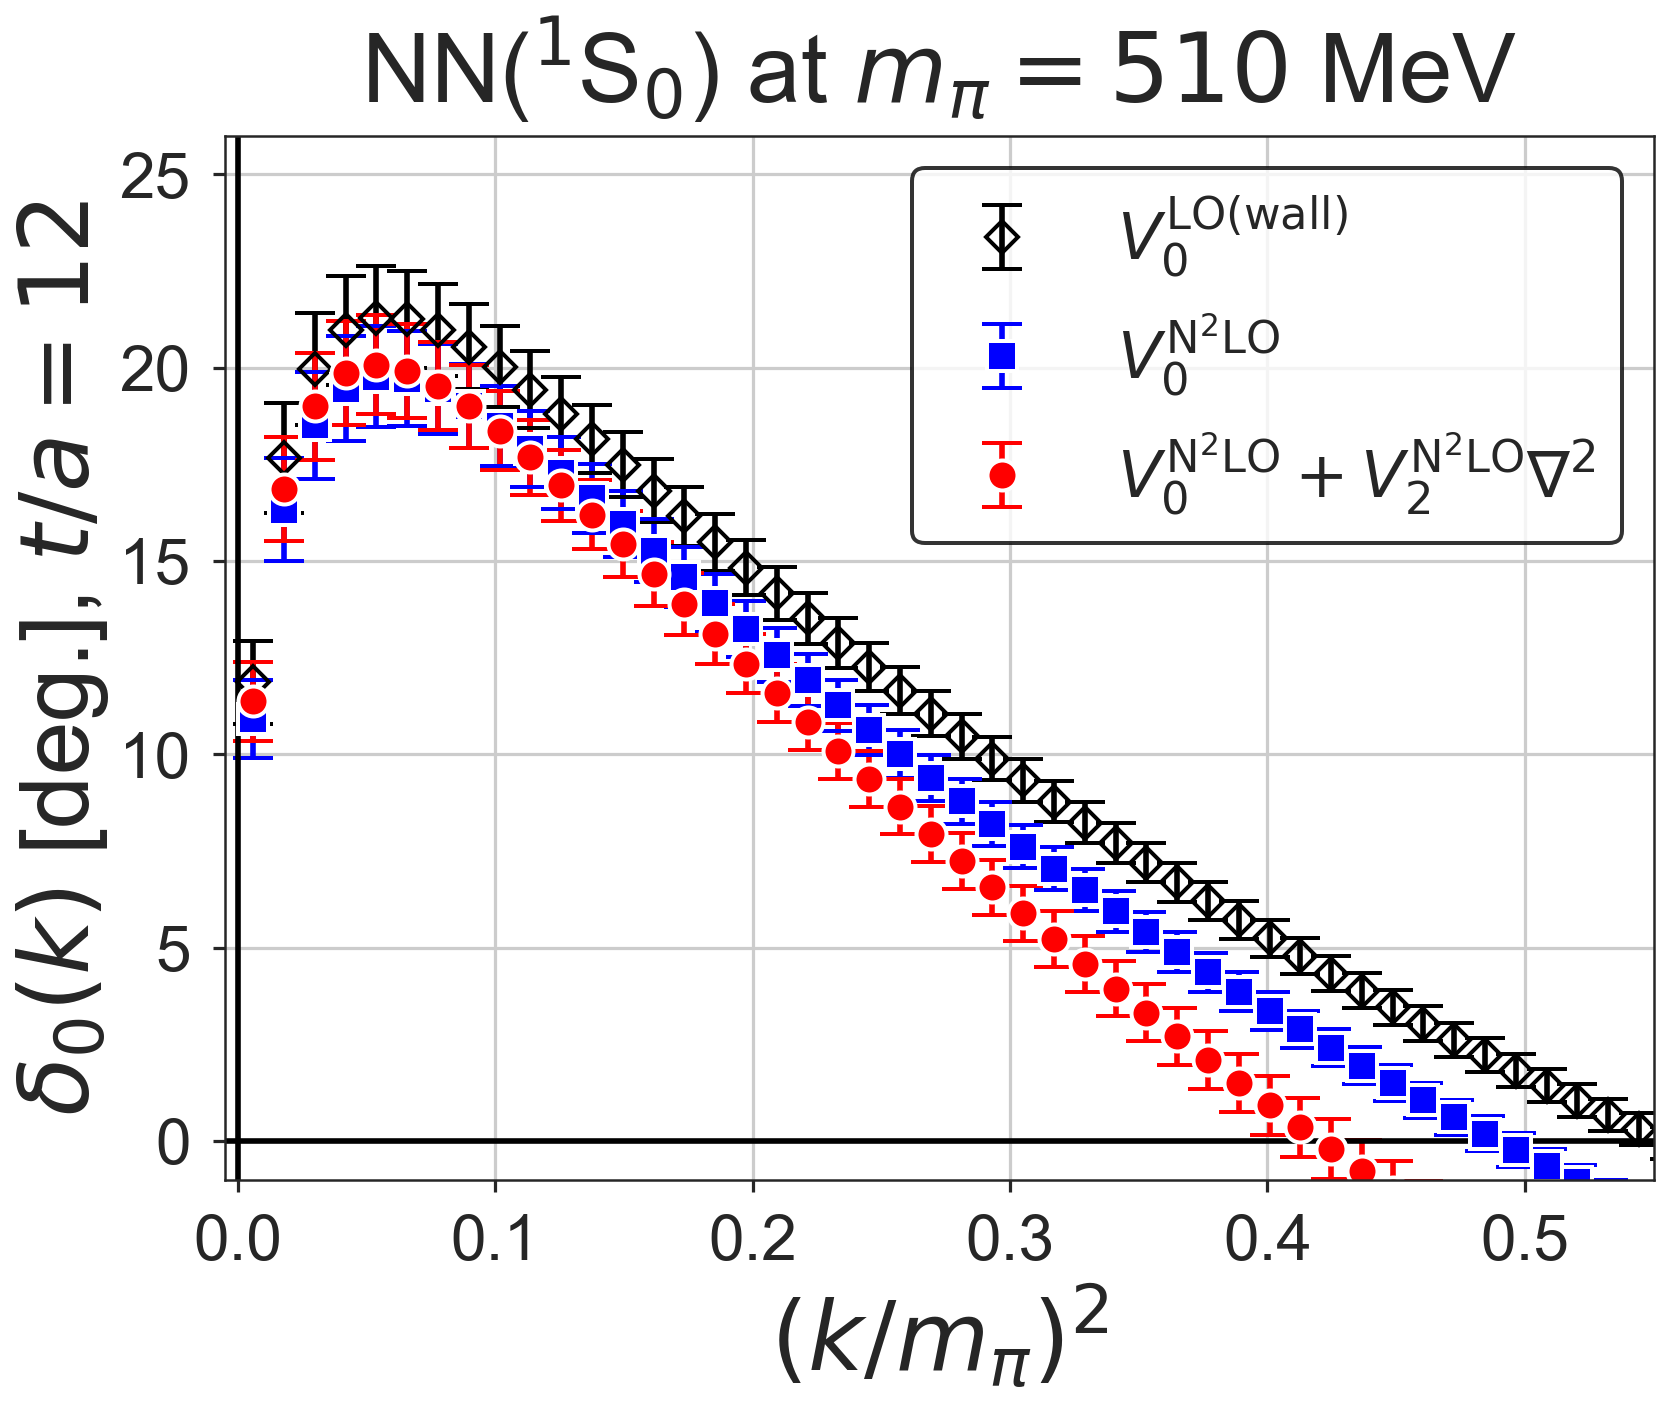

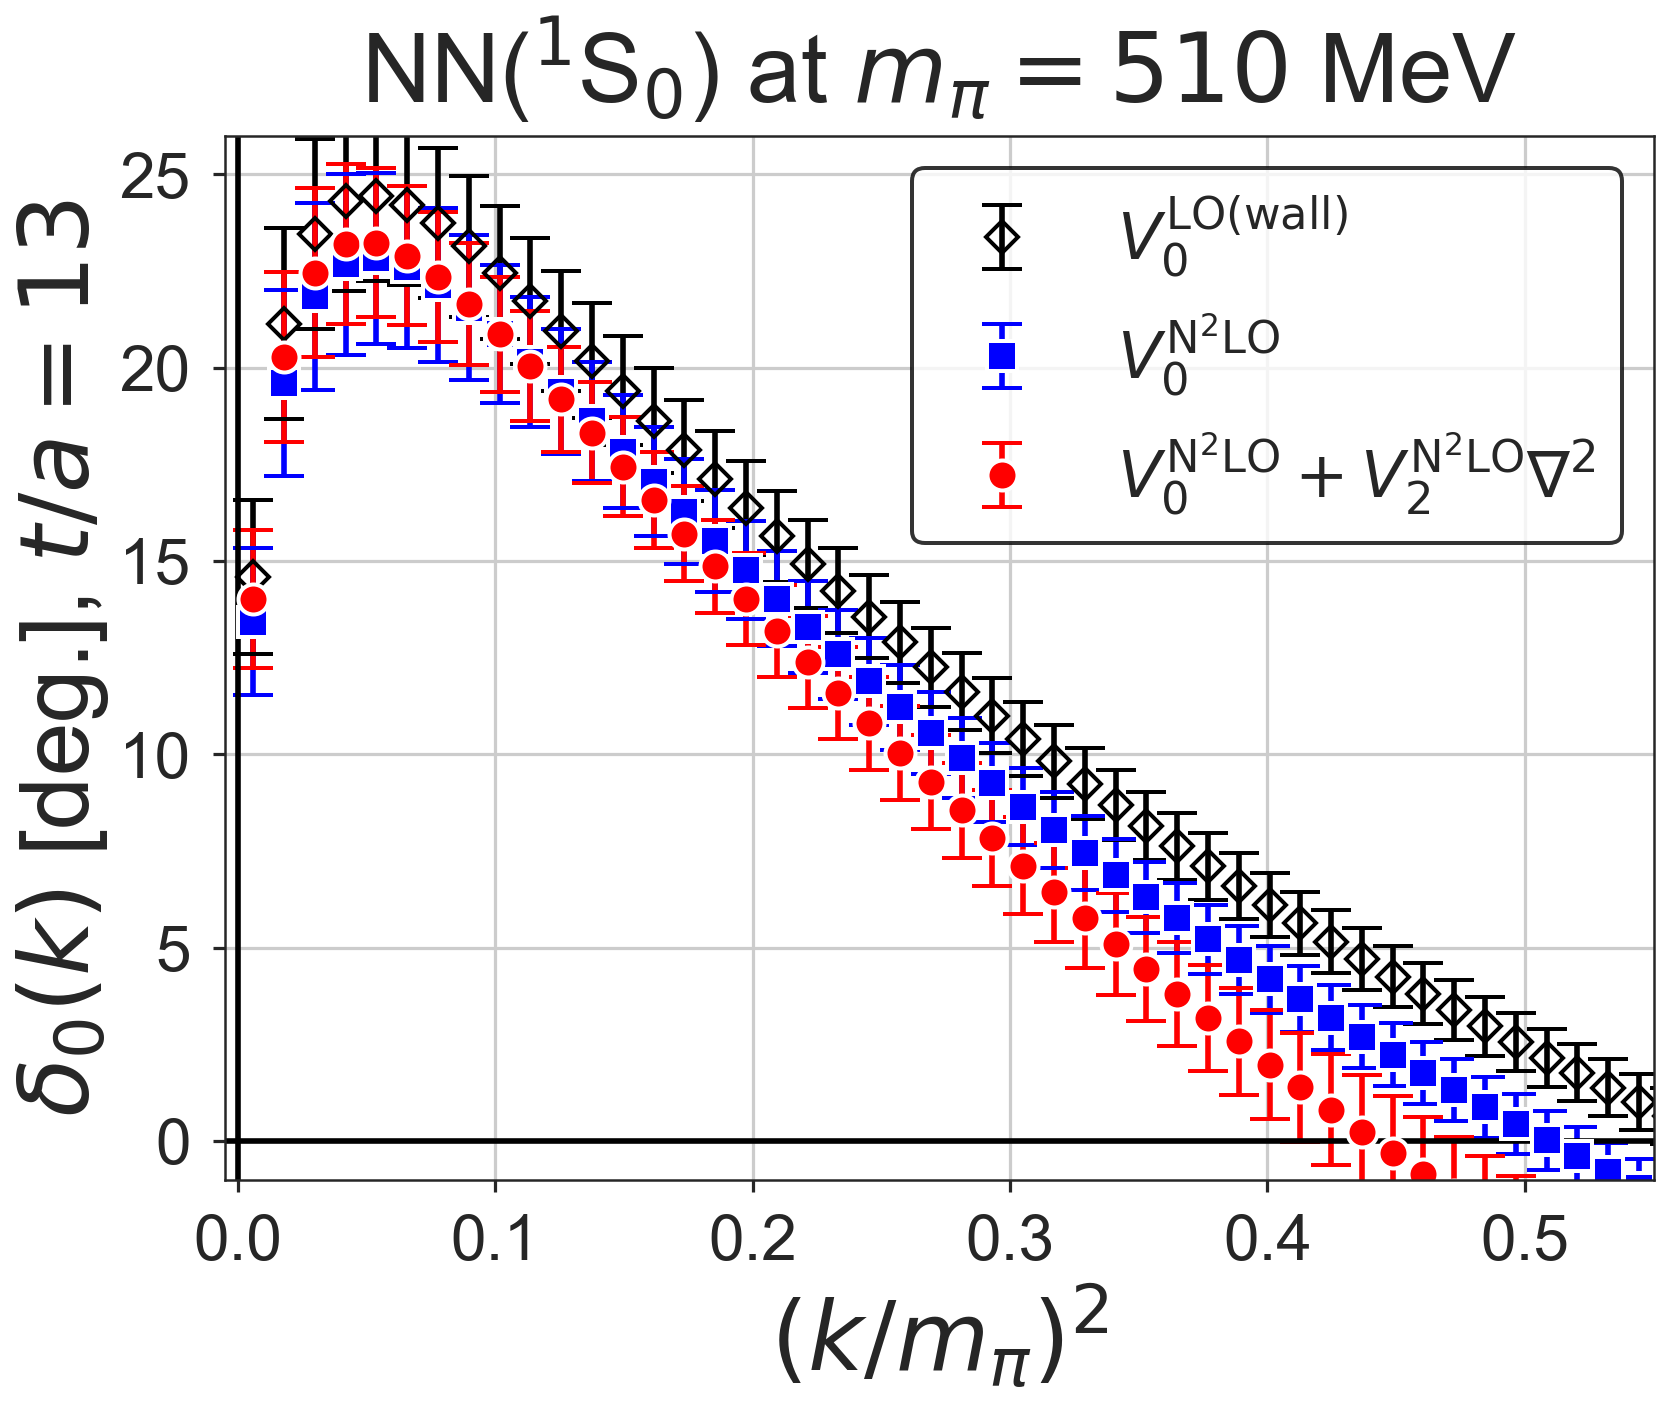

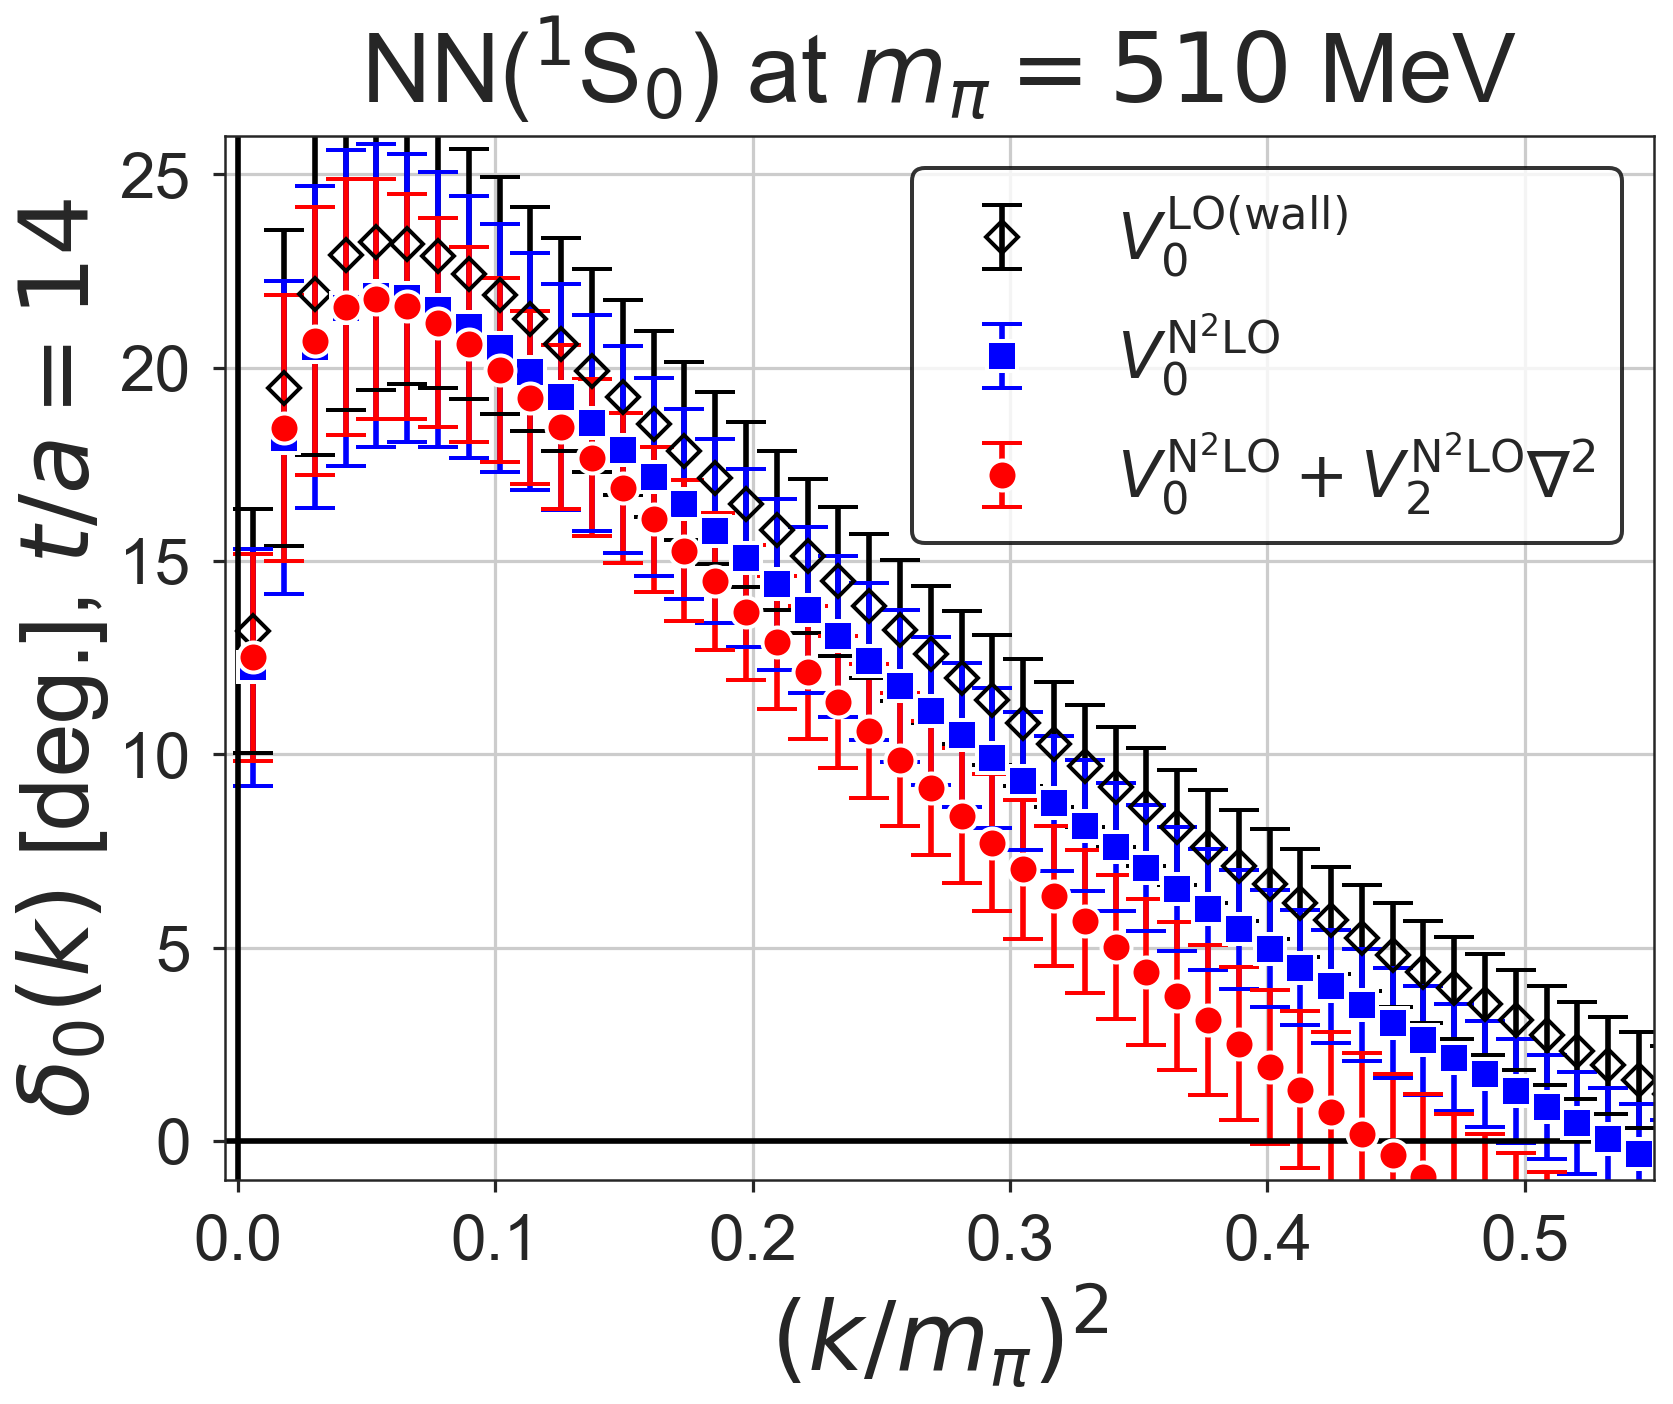

In [40]:
def plot_delta(it):
    fig, ax = plt.subplots()

    src = 'wall'
    k2 = k2s[(src, it)]
    delta_jk = np.rad2deg(deltas_jk[(src, it)])
    mask = delta_jk > 90
    delta_jk[mask] -= 180

    ax.errorbar(k2[1::2]/mpi**2, delta_jk.mean(axis=0)[1::2],
                delta_jk.std(axis=0)[1::2] * np.sqrt(bin_num - 1),
                capsize=10, capthick=2, 
                fmt='D', color='black', mfc='none', mew=2.0, label=r'$V_0^\mathrm{LO(wall)}$')

    src = 'n2lo'
    k2 = k2s[(src, it)]
    delta_jk = np.rad2deg(deltas_jk[(src, it)])
    mask = delta_jk > 90
    delta_jk[mask] -= 180

    ax.errorbar(k2[1::2]/mpi**2, delta_jk.mean(axis=0)[1::2],
                delta_jk.std(axis=0)[1::2] * np.sqrt(bin_num - 1),
                capsize=10, capthick=2, ms=15, 
                fmt='s', color='blue', mec='white', mew=2.0, label=r'$V_0^\mathrm{N^2LO}$')

    src = 'n2lo_w_v2'
    k2 = k2s[(src, it)]
    delta_jk = np.rad2deg(deltas_jk[(src, it)])
    mask = delta_jk > 90
    delta_jk[mask] -= 180
    ax.errorbar(k2[1::2]/mpi**2, delta_jk.mean(axis=0)[1::2],
                delta_jk.std(axis=0)[1::2] * np.sqrt(bin_num - 1),
                capsize=10, capthick=2, ms=15, 
                fmt='o', color='red', mec='white', mew=2.0, label=r'$V_0^\mathrm{N^2LO} + V_2^\mathrm{N^2LO}\nabla^2$')

    ax.set_xlim(-0.005, 0.55)
    ax.set_ylim(-1, 26)
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
    ax.set_ylabel(r'$\delta_0(k)$ [deg.], $t/a = {}$'.format(it), size=48)
    leg = ax.legend(loc='upper right', frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    ax.set_title(r'NN($^1$S$_0$) at $m_\pi = 510$ MeV', size=48, y=1.02)

    fig.savefig('../figs/nn1s0_delta_t{:03d}.pdf'.format(it),
               bbox_inches='tight')
    
for it in [11, 12, 13, 14]:
    plot_delta(it)

11
0.3796 +- 0.0315
0.4081 +- 0.0337
0.3965 +- 0.0329
12
0.3432 +- 0.0342
0.3746 +- 0.0375
0.3578 +- 0.0350
13
0.2736 +- 0.0418
0.2991 +- 0.0467
0.2849 +- 0.0405
14
0.3077 +- 0.0827
0.3328 +- 0.0925
0.3240 +- 0.0778


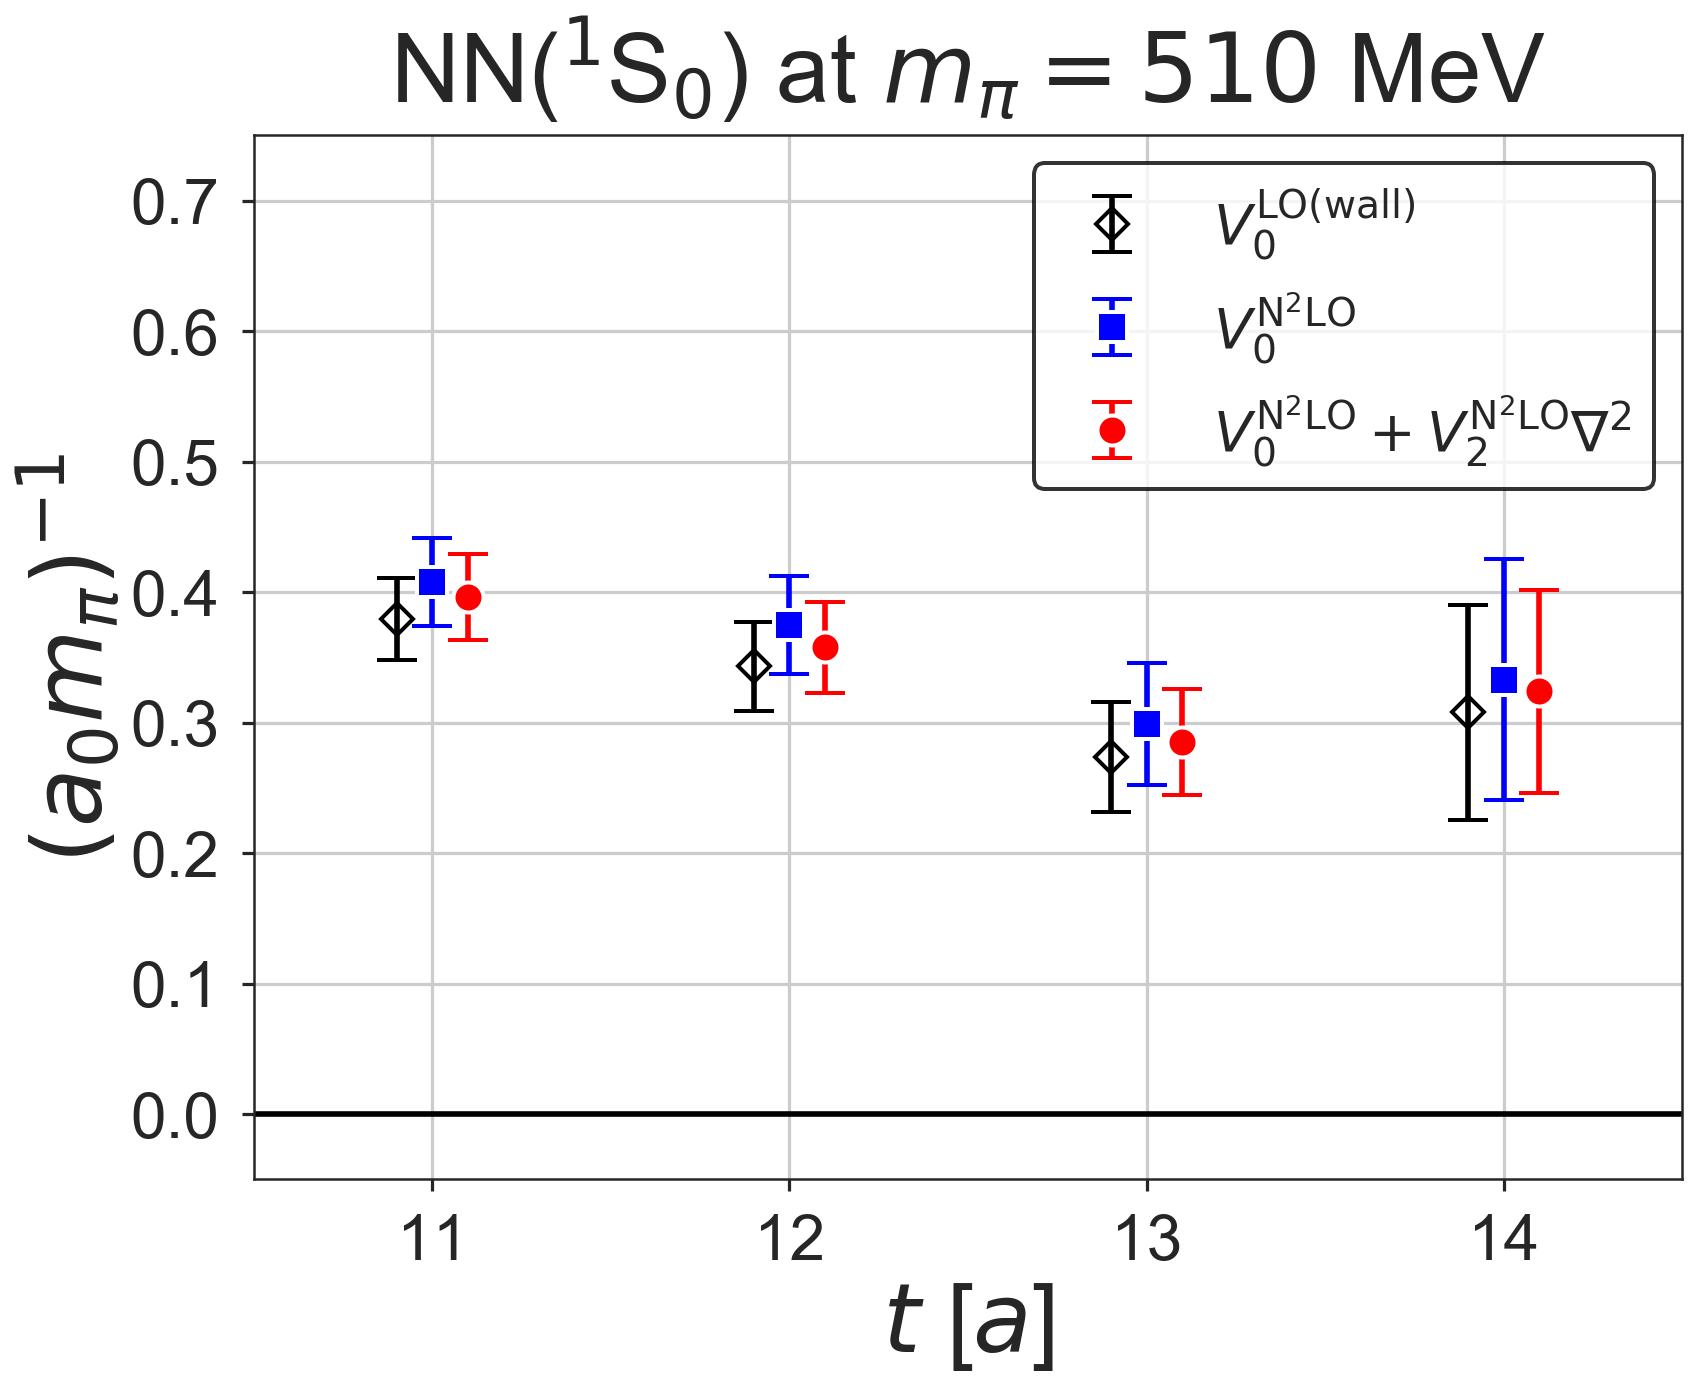

In [41]:
fig, ax = plt.subplots()
a0invs = {}
for it in [11, 12, 13, 14]:
    print(it)
    
    ch = 'wall'
    tmp = (np.sqrt(k2s[(ch,it)])/np.tan(deltas_jk[(ch, it)])).mean(axis=0)[0]/mpi
    tmp_err = (np.sqrt(k2s[(ch,it)])/np.tan(deltas_jk[(ch, it)])).std(axis=0)[0] * np.sqrt(bin_num - 1)/mpi
    a0invs[(ch, it)] = [tmp, tmp_err]

    print('{:.4f} +- {:.4f}'.format(tmp, tmp_err))

    ax.errorbar(it - 0.1, tmp, tmp_err,
                capsize=10, capthick=2,
               fmt='D', color='black', mfc='none', mew=2.0, label=r'$V_0^\mathrm{LO(wall)}$')
    
    ch = 'n2lo'
    tmp = (np.sqrt(k2s[(ch,it)])/np.tan(deltas_jk[(ch, it)])).mean(axis=0)[0]/mpi
    tmp_err = (np.sqrt(k2s[(ch,it)])/np.tan(deltas_jk[(ch, it)])).std(axis=0)[0] * np.sqrt(bin_num - 1)/mpi
    a0invs[(ch, it)] = [tmp, tmp_err]

    print('{:.4f} +- {:.4f}'.format(tmp, tmp_err))

    ax.errorbar(it, tmp, tmp_err, 
                capsize=10, capthick=2, ms=15, mew=2.0, mec='white',
               fmt='s', color='blue', label=r'$V_0^\mathrm{N^2LO}$',
               zorder=3)
    
    ch = 'n2lo_w_v2'
    tmp = (np.sqrt(k2s[(ch,it)])/np.tan(deltas_jk[(ch, it)])).mean(axis=0)[0]/mpi
    tmp_err = (np.sqrt(k2s[(ch,it)])/np.tan(deltas_jk[(ch, it)])).std(axis=0)[0] * np.sqrt(bin_num - 1)/mpi

    a0invs[(ch, it)] = [tmp, tmp_err]

    print('{:.4f} +- {:.4f}'.format(tmp, tmp_err))

    ax.errorbar(it + 0.1, tmp, tmp_err,
                capsize=10, capthick=2, ms=15,
               fmt='o', color='red', mew=2.0, mec='white', label=r'$V_0^\mathrm{N^2LO} + V_2^\mathrm{N^2LO}\nabla^2$',
               zorder=3)

#    ax.set_xlim(-0.005,0.105)
#ax.set_xlim(-1, 20.8)
ax.set_xlim(10.5, 14.5)
ax.set_ylim(-0.05, 0.75)
ax.axhline(0, c='black')
ax.axvline(0, c='black')
ax.set_xlabel(r'$t$ [$a$]', size=48)
ax.set_ylabel(r'$(a_0 m_\pi)^{-1}$', size=48)
ll, hh = ax.get_legend_handles_labels()
leg = ax.legend(ll[:3], hh[:3], frameon=True,
               ncol=1, fontsize=28)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_title(r'NN($^1$S$_0$) at $m_\pi = 510$ MeV', size=48, y=1.02)
fig.savefig('../figs/nn1s0_a0inv_t_pot_dep.pdf', bbox_inches='tight')